In [1]:
!nvidia-smi

Fri Mar 14 14:30:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   31C    P0             41W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [2]:
#!pip install tensorflow
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Import libraries

In [3]:
import tensorflow as tf # Access to models, datasets and training
from tensorflow.keras.datasets import cifar100 # Access to CIFAR-100
from tensorflow.keras.applications import ResNet50 # Access to pre-trained model
from tensorflow.keras import layers, models, optimizers # Access to building blocks of a model
from tensorflow.keras.models import load_model # Ability to load best_saved model
from tensorflow import keras # Access to stuff for model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger
from sklearn.model_selection import train_test_split # To help split dataset up
from sklearn.metrics import confusion_matrix, classification_report # Analysis of model train, val & test
import numpy as np # Manipulate data
import pandas as pd # Statistical analysis of data
import seaborn as sns
import matplotlib.pyplot as plt # Plot data

# Function definitions

In [1]:
def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()


def class_distrib(y, labels_names, dataset_name):
        counts = pd.DataFrame(data=y).value_counts().sort_index()
        #print(f"counts:\n{counts}")
        fig, ax = plt.subplots(figsize=(20,10))
        ax.bar(labels_names, counts)
        ax.set_xticklabels(labels_names, rotation=90, fontsize=15)
        plt.title(f"Distribution of '{dataset_name}' Dataset", fontsize=25)
        plt.grid()
        plt.tight_layout()
        plt.show()
        
def augment_dataset(x, y):
        x = tf.image.resize(x, (224, 224))  # Resize images
        x = tf.image.random_flip_left_right(x)  # Random horizontal flip
        x = tf.image.random_brightness(x, max_delta=0.2)  # Adjust brightness
        x = tf.image.random_contrast(x, lower=0.8, upper=1.2)  # Adjust contrast
        y = tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))  # One-hot encode labels
        return x, y
        
def plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc):
        # Plot Training and Validation Loss
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        plt.plot(epochs, train_loss, label='Training Loss')
        plt.plot(epochs, val_loss, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()
        plt.grid()

        # Plot Training and Validation Accuracy
        plt.subplot(1, 2, 2)
        plt.plot(epochs, train_acc, label='Training Accuracy')
        plt.plot(epochs, val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.legend()
        plt.grid()

        plt.tight_layout()
        plt.show()
    

# Dropout(0.6), weight_decay(3e-2)

In [ ]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64
    
    train_dataset = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

   val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model.h5', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    checkpoint_fine_tune = ModelCheckpoint('best_model_fine_tune.h5', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model.h5')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset_.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune.h5')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.6), weight_decay(3e-2), l2(3e-2)

In [ ]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64
    
    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    #train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #                 .batch(batch_size)
    #                 .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_#.concatenate(train_dataset_aug)
    
    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-2) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model.h5', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model.h5')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset_.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune.h5')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist

# Dropout(0.6), L2Reg(3e-2), weight_decay(3e-2), train_augmentation

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step
X_temp.shape: (8000, 32, 32, 3)

X_temp_val.shape: (4000, 32, 32, 3)
y_temp_val.shape: (4000, 1)
X_temp_test.shape: (4000, 32, 32, 3)
y_temp_test.shape: (4000, 1)

X_train.shape: (42000, 32, 32, 3)
y_train.shape: (42000, 1)
X_val.shape: (9000, 32, 32, 3)
y_val.shape: (9000, 1)
X_test.shape: (9000, 32, 32, 3)
y_test.shape: (9000, 1)

labels[4270].shape: (1,)
imgs[4270].shape: (32, 32, 3)


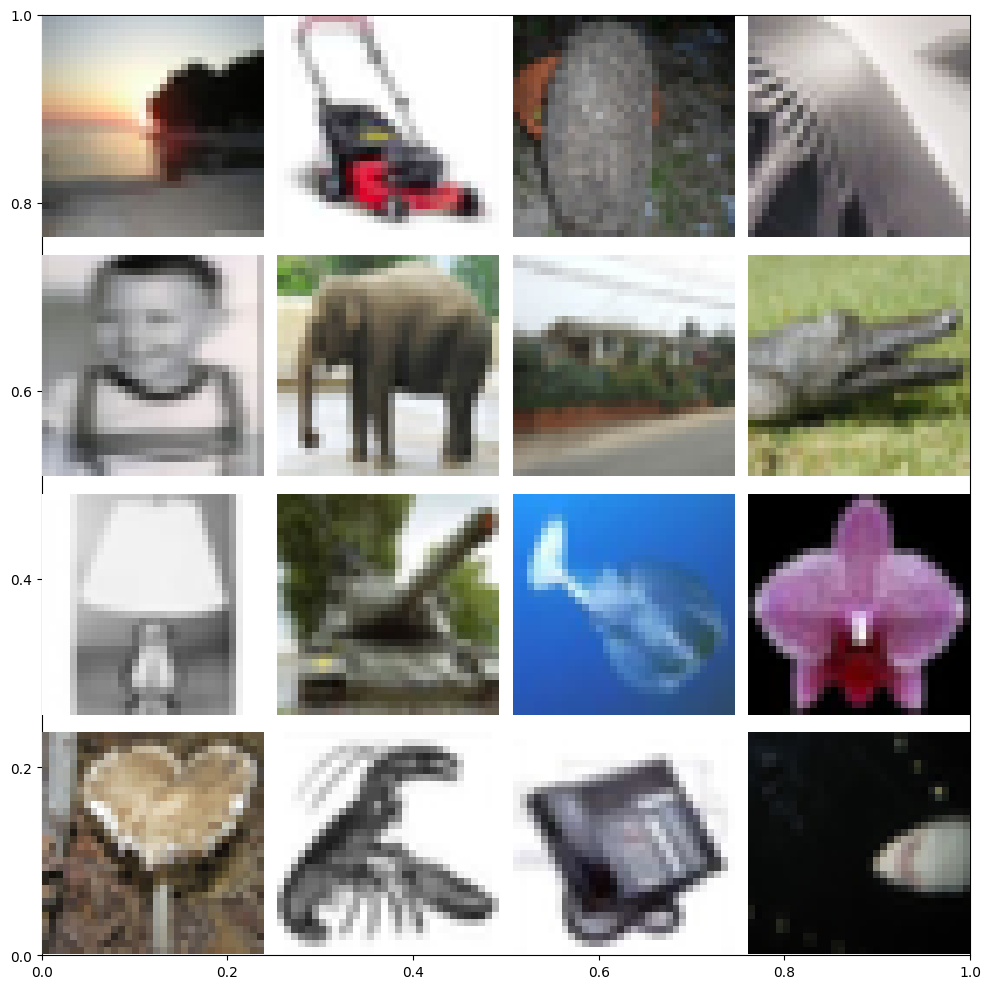

labels[2306].shape: (1,)
imgs[2306].shape: (32, 32, 3)


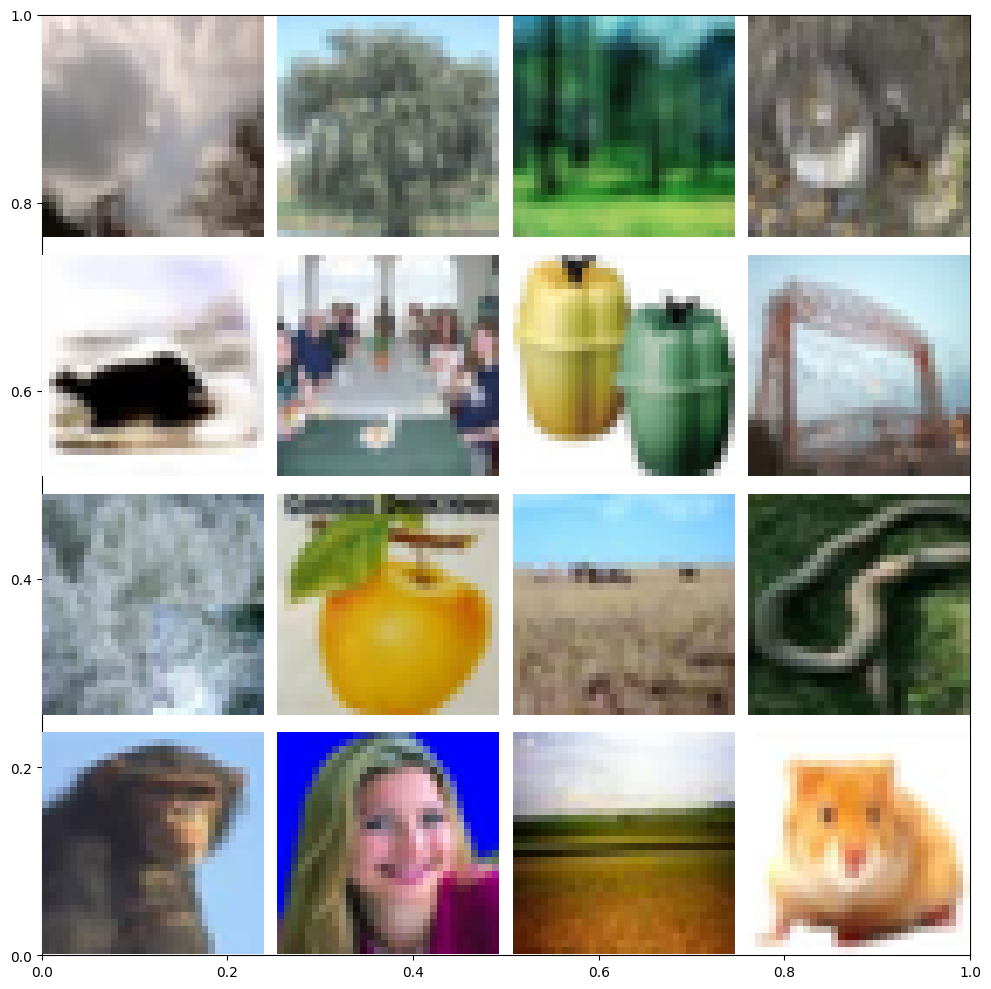

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


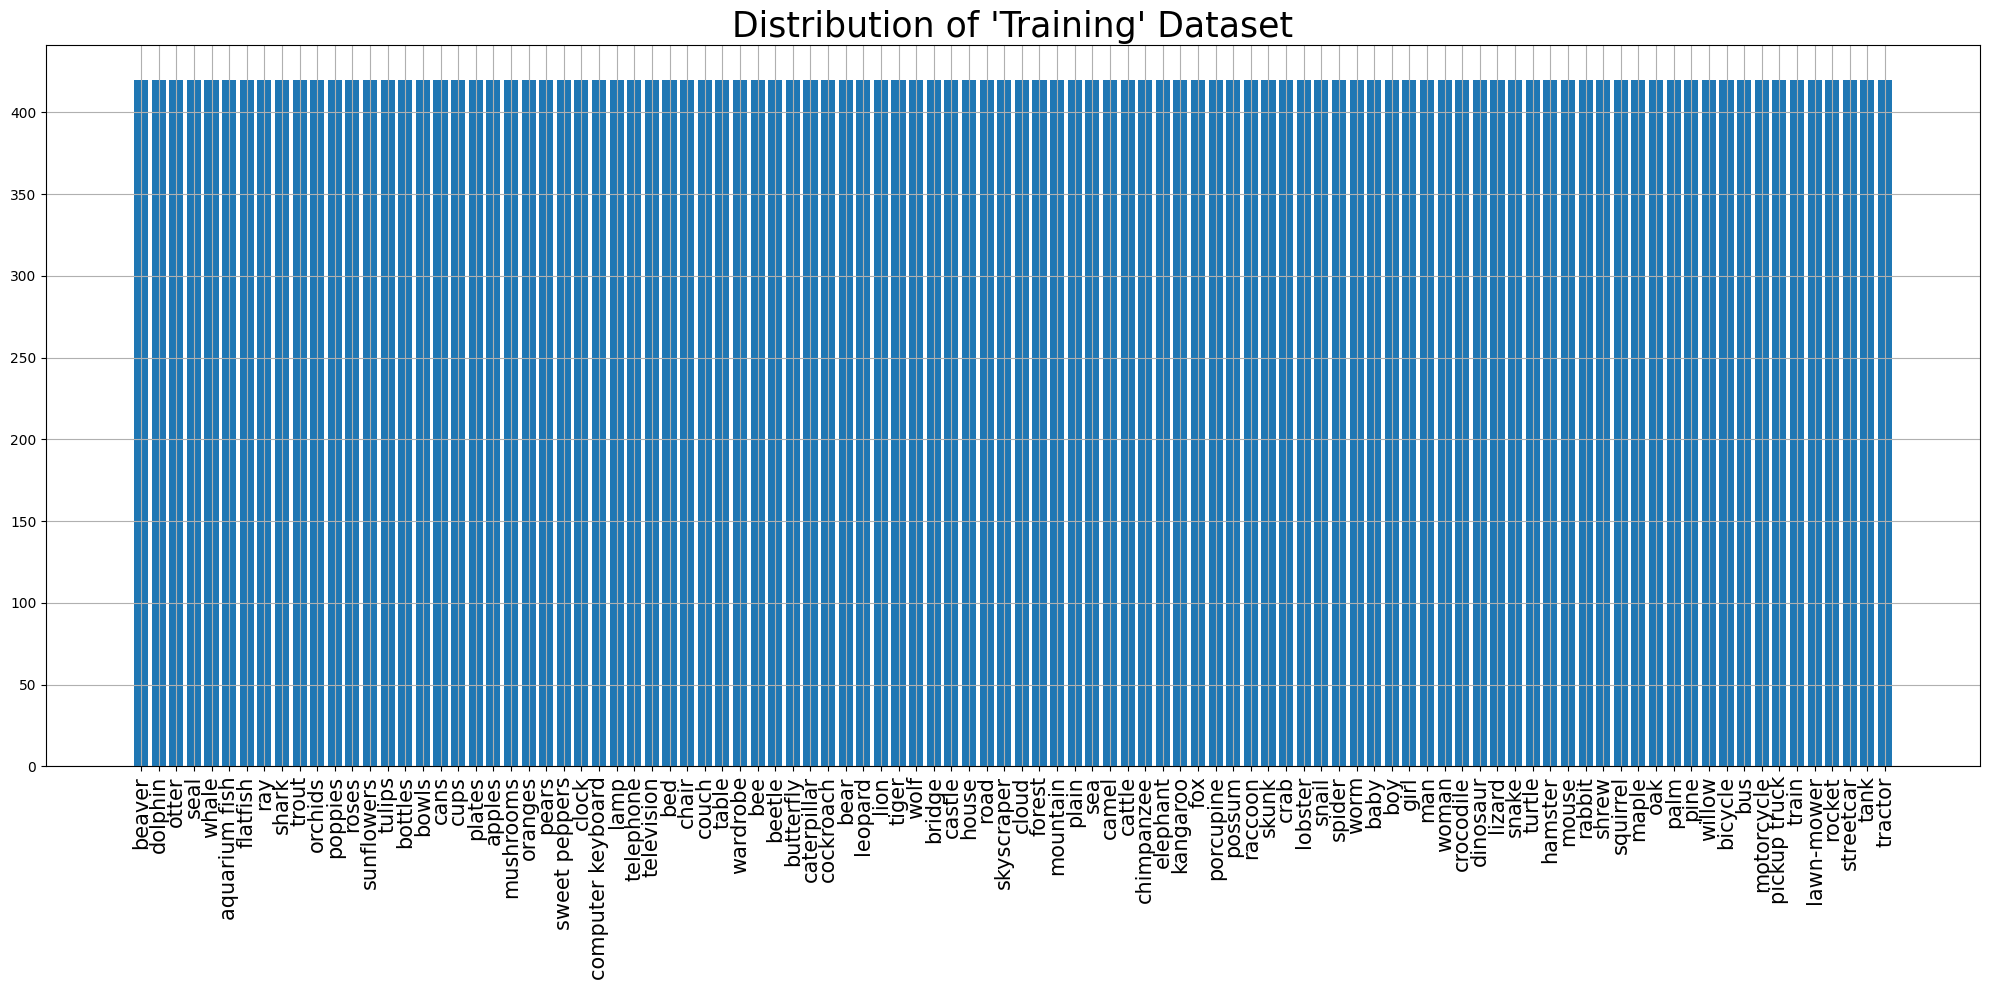

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


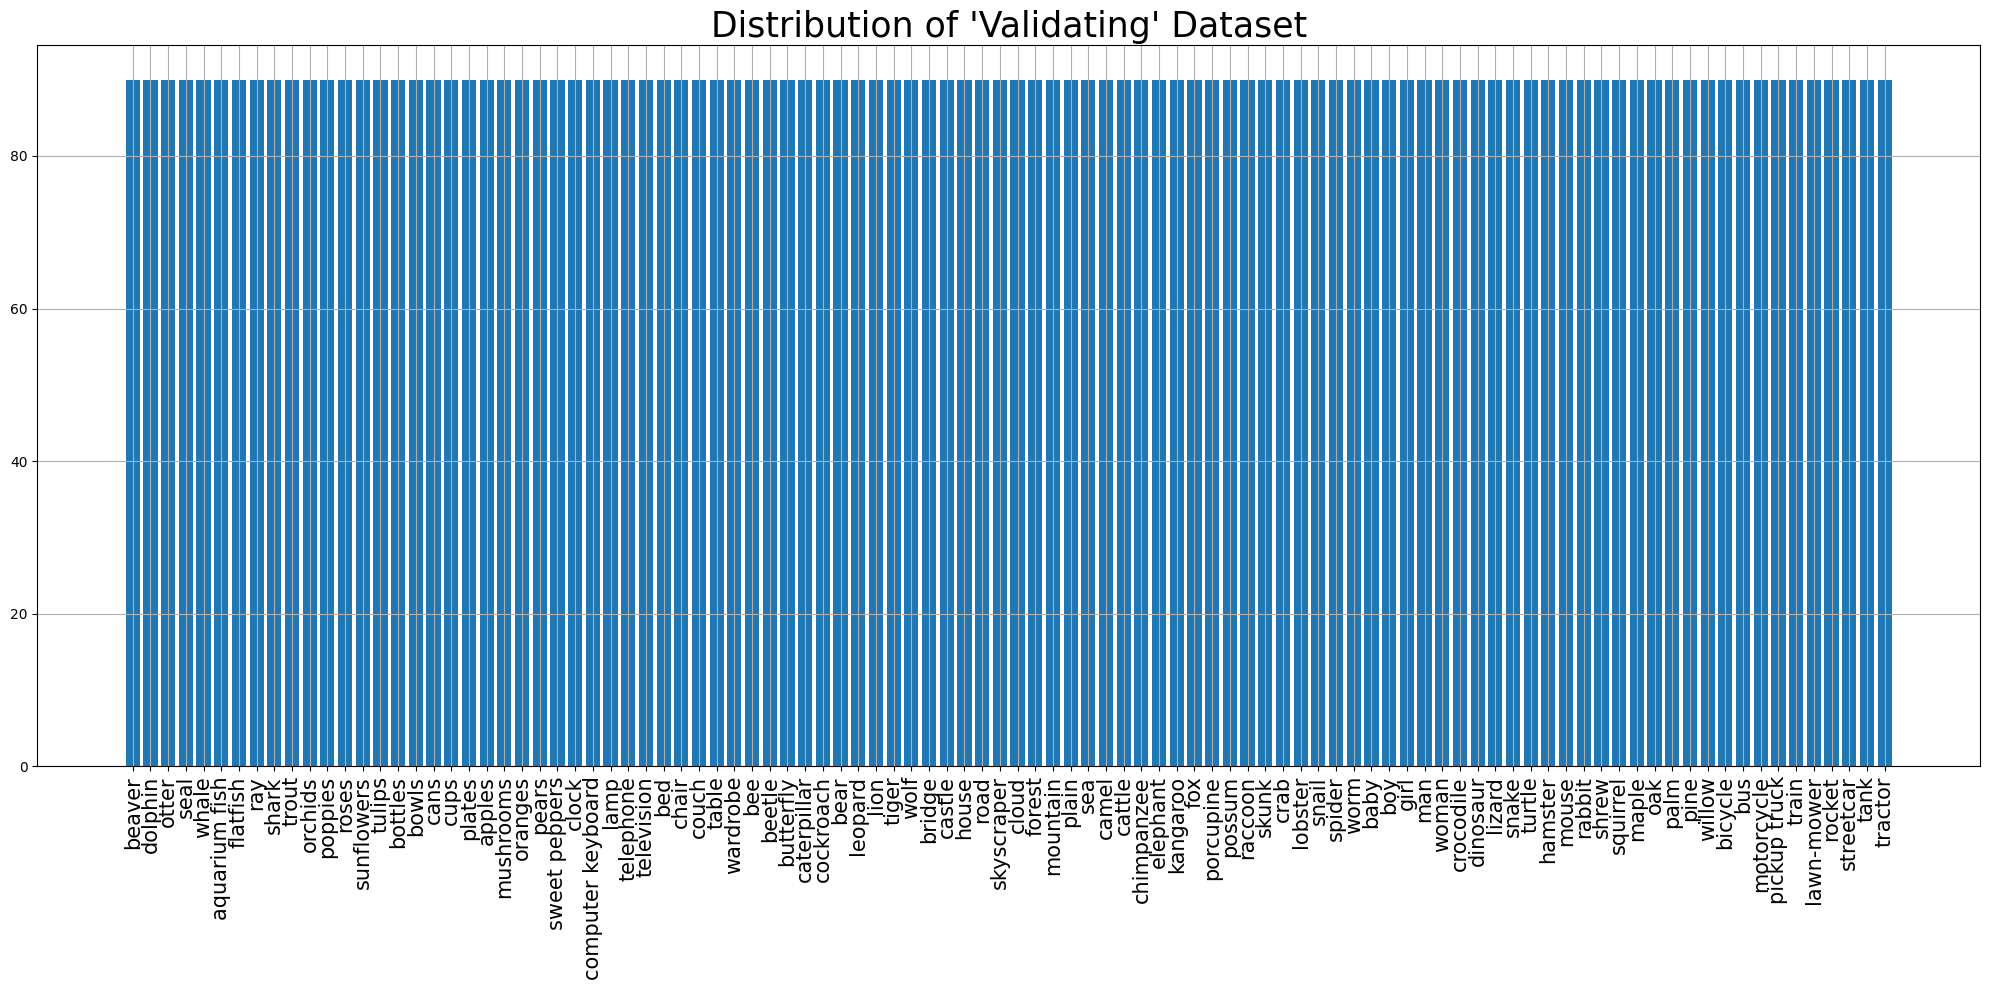

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


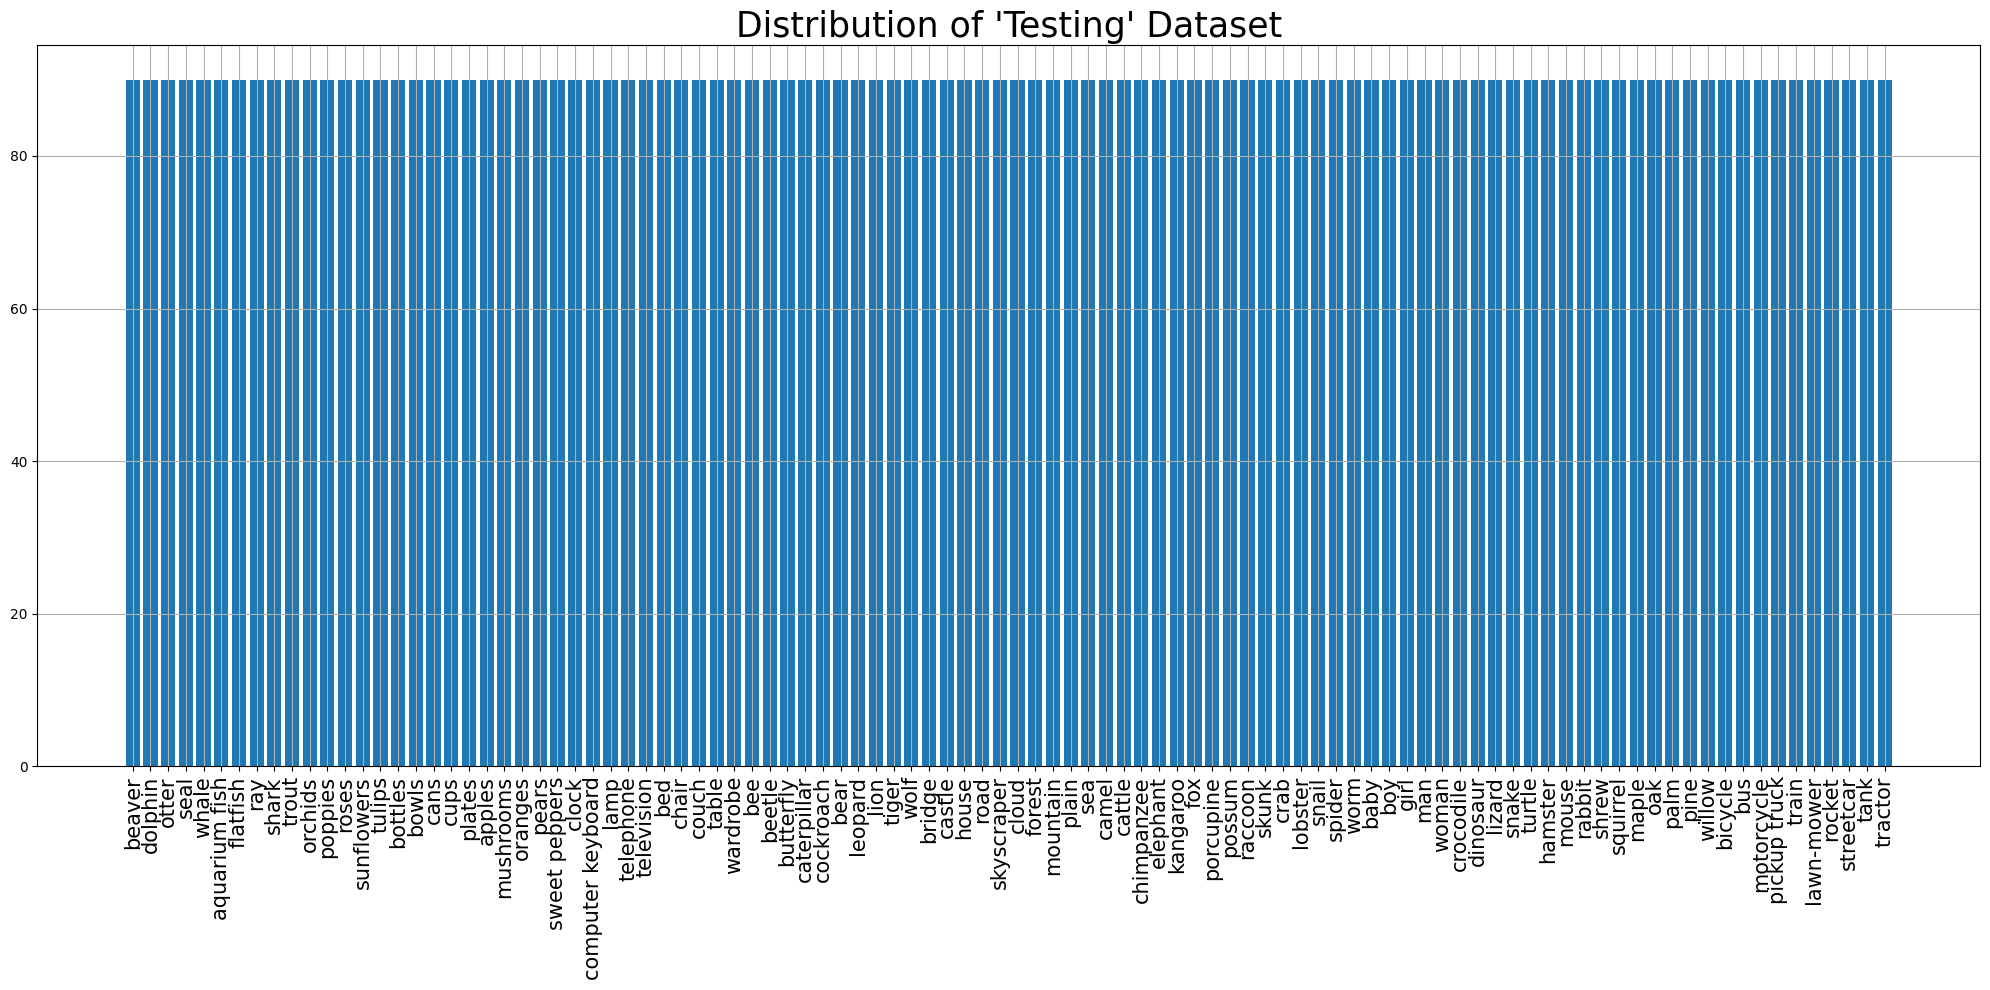

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.nda

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 57s 58ms/step - accuracy: 0.3832 - f1_score: 0.3787 - loss: 2.5389 - precision: 0.6965 - val_accuracy: 0.5993 - val_f1_score: 0.5958 - val_loss: 1.4477 - val_precision: 0.8044
Epoch 2/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5885 - f1_score: 0.5855 - loss: 1.4474 - precision: 0.7761 - val_accuracy: 0.6163 - val_f1_score: 0.6133 - val_loss: 1.3704 - val_precision: 0.7904
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6402 - f1_score: 0.6376 - loss: 1.2373 - precision: 0.7996 - val_accuracy: 0.6253 - val_f1_score: 0.6222 - val_loss: 1.3377 - val_precision: 0.7861
Epoch 4/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.6735 - f1_score: 0.6706 - loss: 1.1020 - precision: 0.8112 - val_accuracy: 0.6300 - val_f1_score: 0.6300 - val_loss: 1.3314 - val_precision: 0.7725
Epoch 5/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 18s 28ms/step - accuracy: 0.7061 - f1_score: 0.7033 - loss: 0.9789 - precision: 0.8295 - val_acc

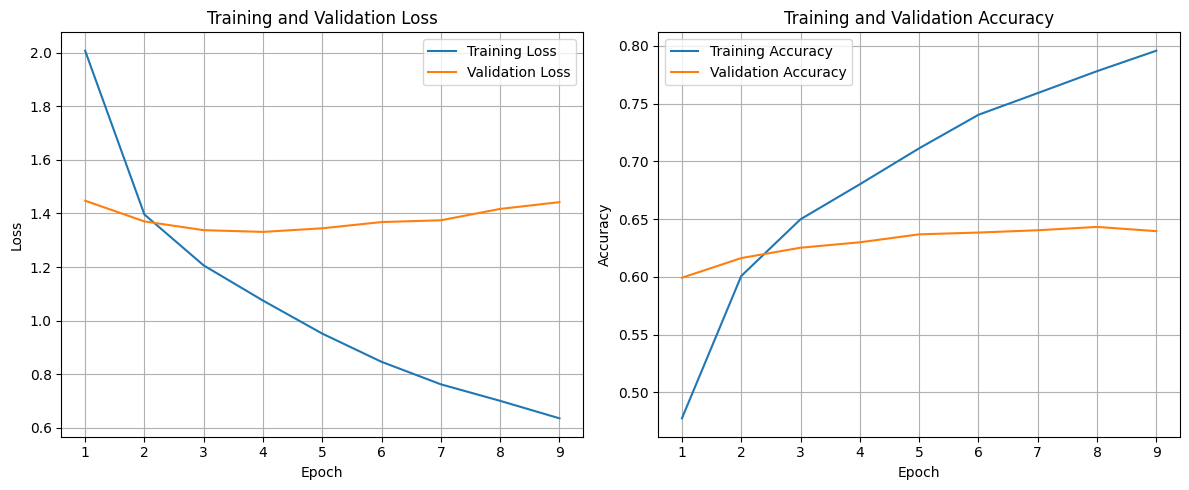

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.6244 - f1_score: 0.6183 - loss: 1.3475 - precision: 0.7676
Test Accuracy: 63.57%
Test Loss: 131.81%
Test Precision: 77.76%
Test F1 Scores (Per Class): [82.20858  77.83783  55.49738  31.666664 36.66666  67.37968  62.06896
 68.42105  80.473366 81.17647  56.774185 44.57831  67.92453  59.512184
 56.852787 59.893044 79.775276 70.69766  59.139782 57.894737 77.8443
 73.11827  82.08092  76.190475 79.99999  59.04761  48.863632 44.79166
 77.15736  64.86486  61.363636 69.36415  51.89873  47.368416 64.24241
 30.303024 69.135796 56.15763  51.034473 86.22754  69.62025  79.59184
 56.55172  71.50259  52.017933 50.95541  47.736626 52.282154 81.60919
 78.49462  44.2211   68.53932  64.088394 87.86127  64.90066  40.217384
 77.7202   71.56862  75.94936  53.947365 77.01149  71.06599  63.354034
 61.956512 42.647057 48.93617  67.105255 52.892555 86.03351  82.142845
 63.203453 71.428566 36.871502 58.59872  29.999996 80.64516  83.9779
 55.555553 67.92453  

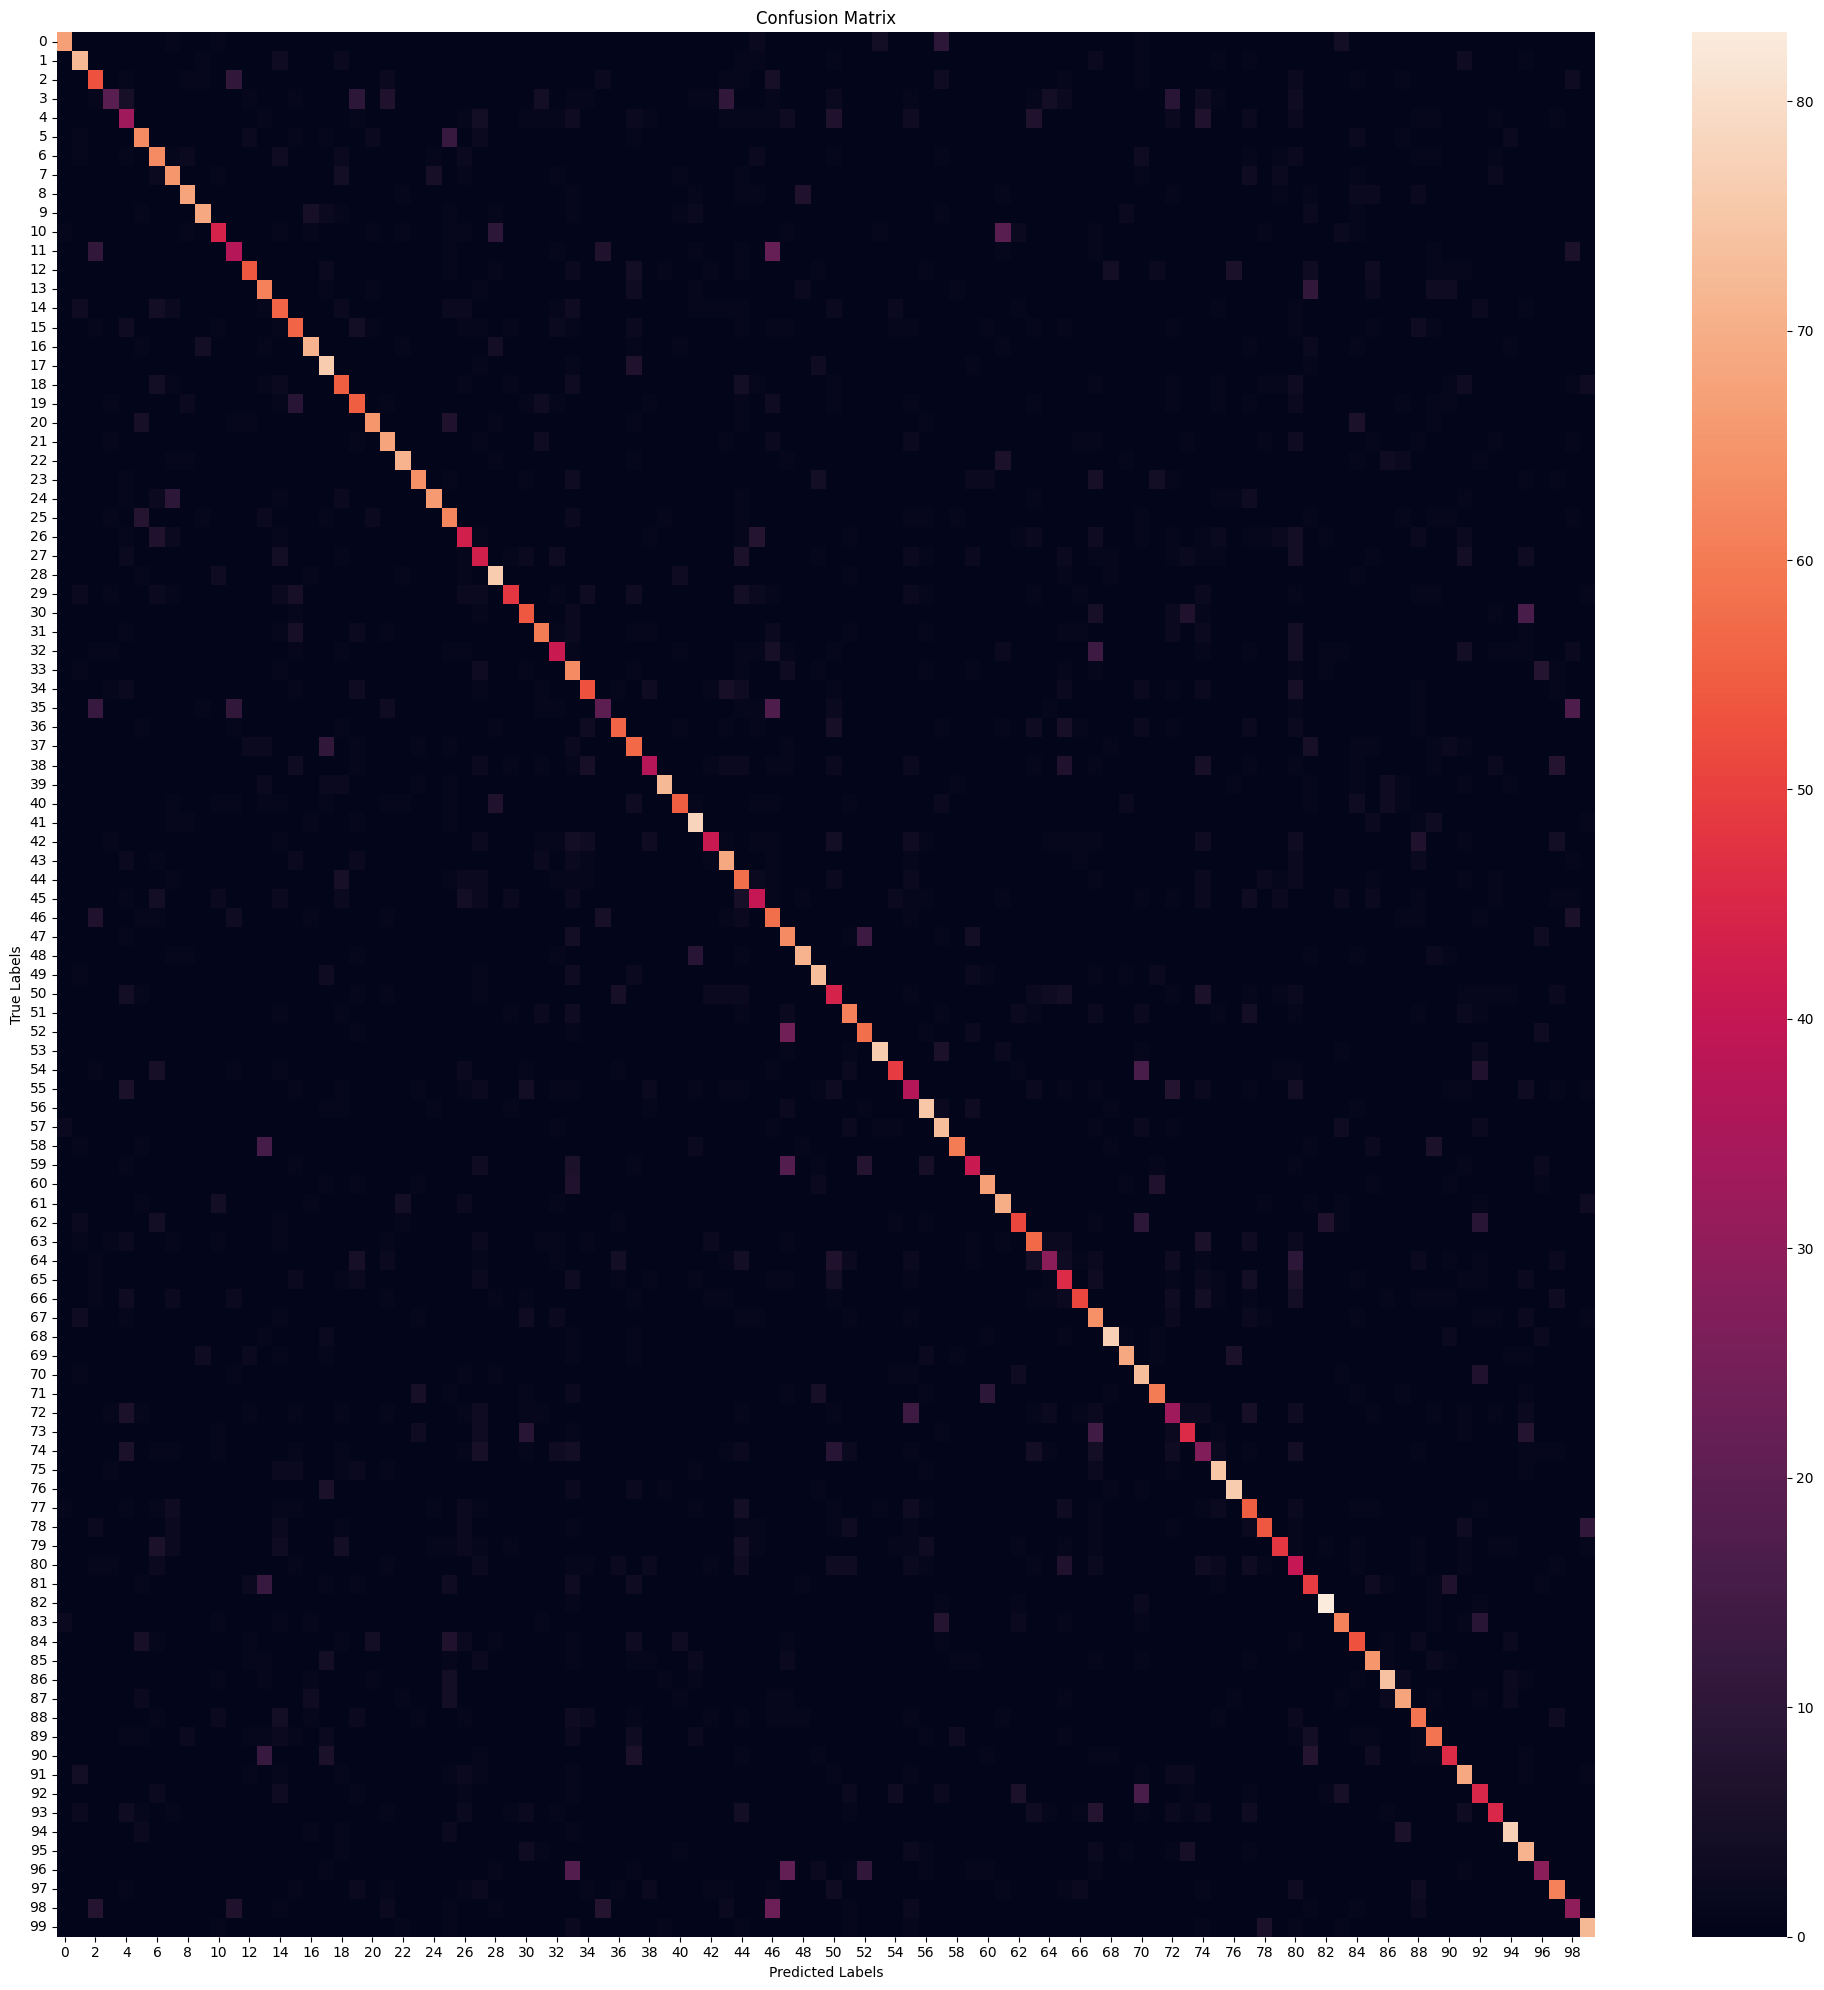

                   precision    recall  f1-score   support

           beaver       0.92      0.74      0.82        90
          dolphin       0.76      0.80      0.78        90
            otter       0.52      0.59      0.55        90
             seal       0.63      0.21      0.32        90
            whale       0.37      0.37      0.37        90
    aquarium fish       0.65      0.70      0.67        90
         flatfish       0.56      0.70      0.62        90
              ray       0.65      0.72      0.68        90
            shark       0.86      0.76      0.80        90
            trout       0.86      0.77      0.81        90
          orchids       0.68      0.49      0.57        90
          poppies       0.49      0.41      0.45        90
            roses       0.78      0.60      0.68        90
       sunflowers       0.53      0.68      0.60        90
           tulips       0.52      0.62      0.57        90
          bottles       0.58      0.62      0.60       

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 24,619,748 (93.92 MB)

 Non-trainable params: 45,440 (177.50 KB)

Epoch 1/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 131s 116ms/step - accuracy: 0.5562 - f1_score: 0.5556 - loss: 1.6464 - precision: 0.7658 - val_accuracy: 0.7227 - val_f1_score: 0.7211 - val_loss: 0.9495 - val_precision: 0.8305
Epoch 2/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.7582 - f1_score: 0.7557 - loss: 0.8126 - precision: 0.8653 - val_accuracy: 0.7456 - val_f1_score: 0.7441 - val_loss: 0.8899 - val_precision: 0.8323
Epoch 3/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.8437 - f1_score: 0.8413 - loss: 0.5118 - precision: 0.9127 - val_accuracy: 0.7524 - val_f1_score: 0.7516 - val_loss: 0.8914 - val_precision: 0.8256
Epoch 4/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.8981 - f1_score: 0.8961 - loss: 0.3330 - precision: 0.9419 - val_accuracy: 0.7599 - val_f1_score: 0.7595 - val_loss: 0.9071 - val_precision: 0.8235
Epoch 5/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.9397 - f1_score: 0.9381 - loss: 0.2060 - precision: 0.9639 - val_a

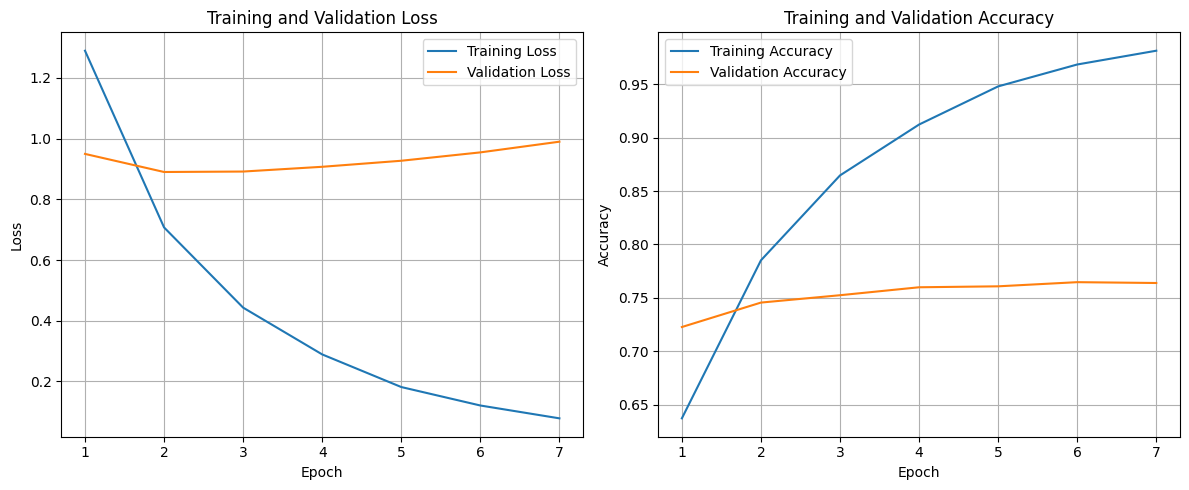

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7357 - f1_score: 0.7270 - loss: 0.9217 - precision: 0.8190
Test Accuracy: 74.30%
Test Loss: 90.23%
Test Precision: 82.69%
Test F1 Scores (Per Class): [88.26815  84.04254  64.893616 65.8385   52.459015 75.14451  78.78787
 74.444435 91.52542  89.65517  69.51219  49.72375  72.222206 74.999985
 74.03315  76.50272  82.53968  79.38144  62.5641   73.68421  87.83068
 89.61748  85.24589  78.88888  81.675385 69.005844 64.80447  65.47618
 81.56424  74.69879  67.796616 82.22221  60.869564 69.148926 79.166664
 38.410587 80.87432  71.99999  69.66292  92.48554  77.01149  91.11111
 75.55555  79.78141  69.005844 65.19337  56.084652 58.100555 88.17203
 86.17021  51.807224 78.68852  69.791664 91.304344 72.63681  43.33333
 83.060104 81.11111  87.49999  62.1118   81.31868  76.74419  65.55555
 75.55555  58.959538 68.0203   77.456635 71.35134  90.32257  89.01098
 72.18934  79.78141  48.61878  68.263466 57.142853 87.15083  83.24323
 72.51461  74.69879  7

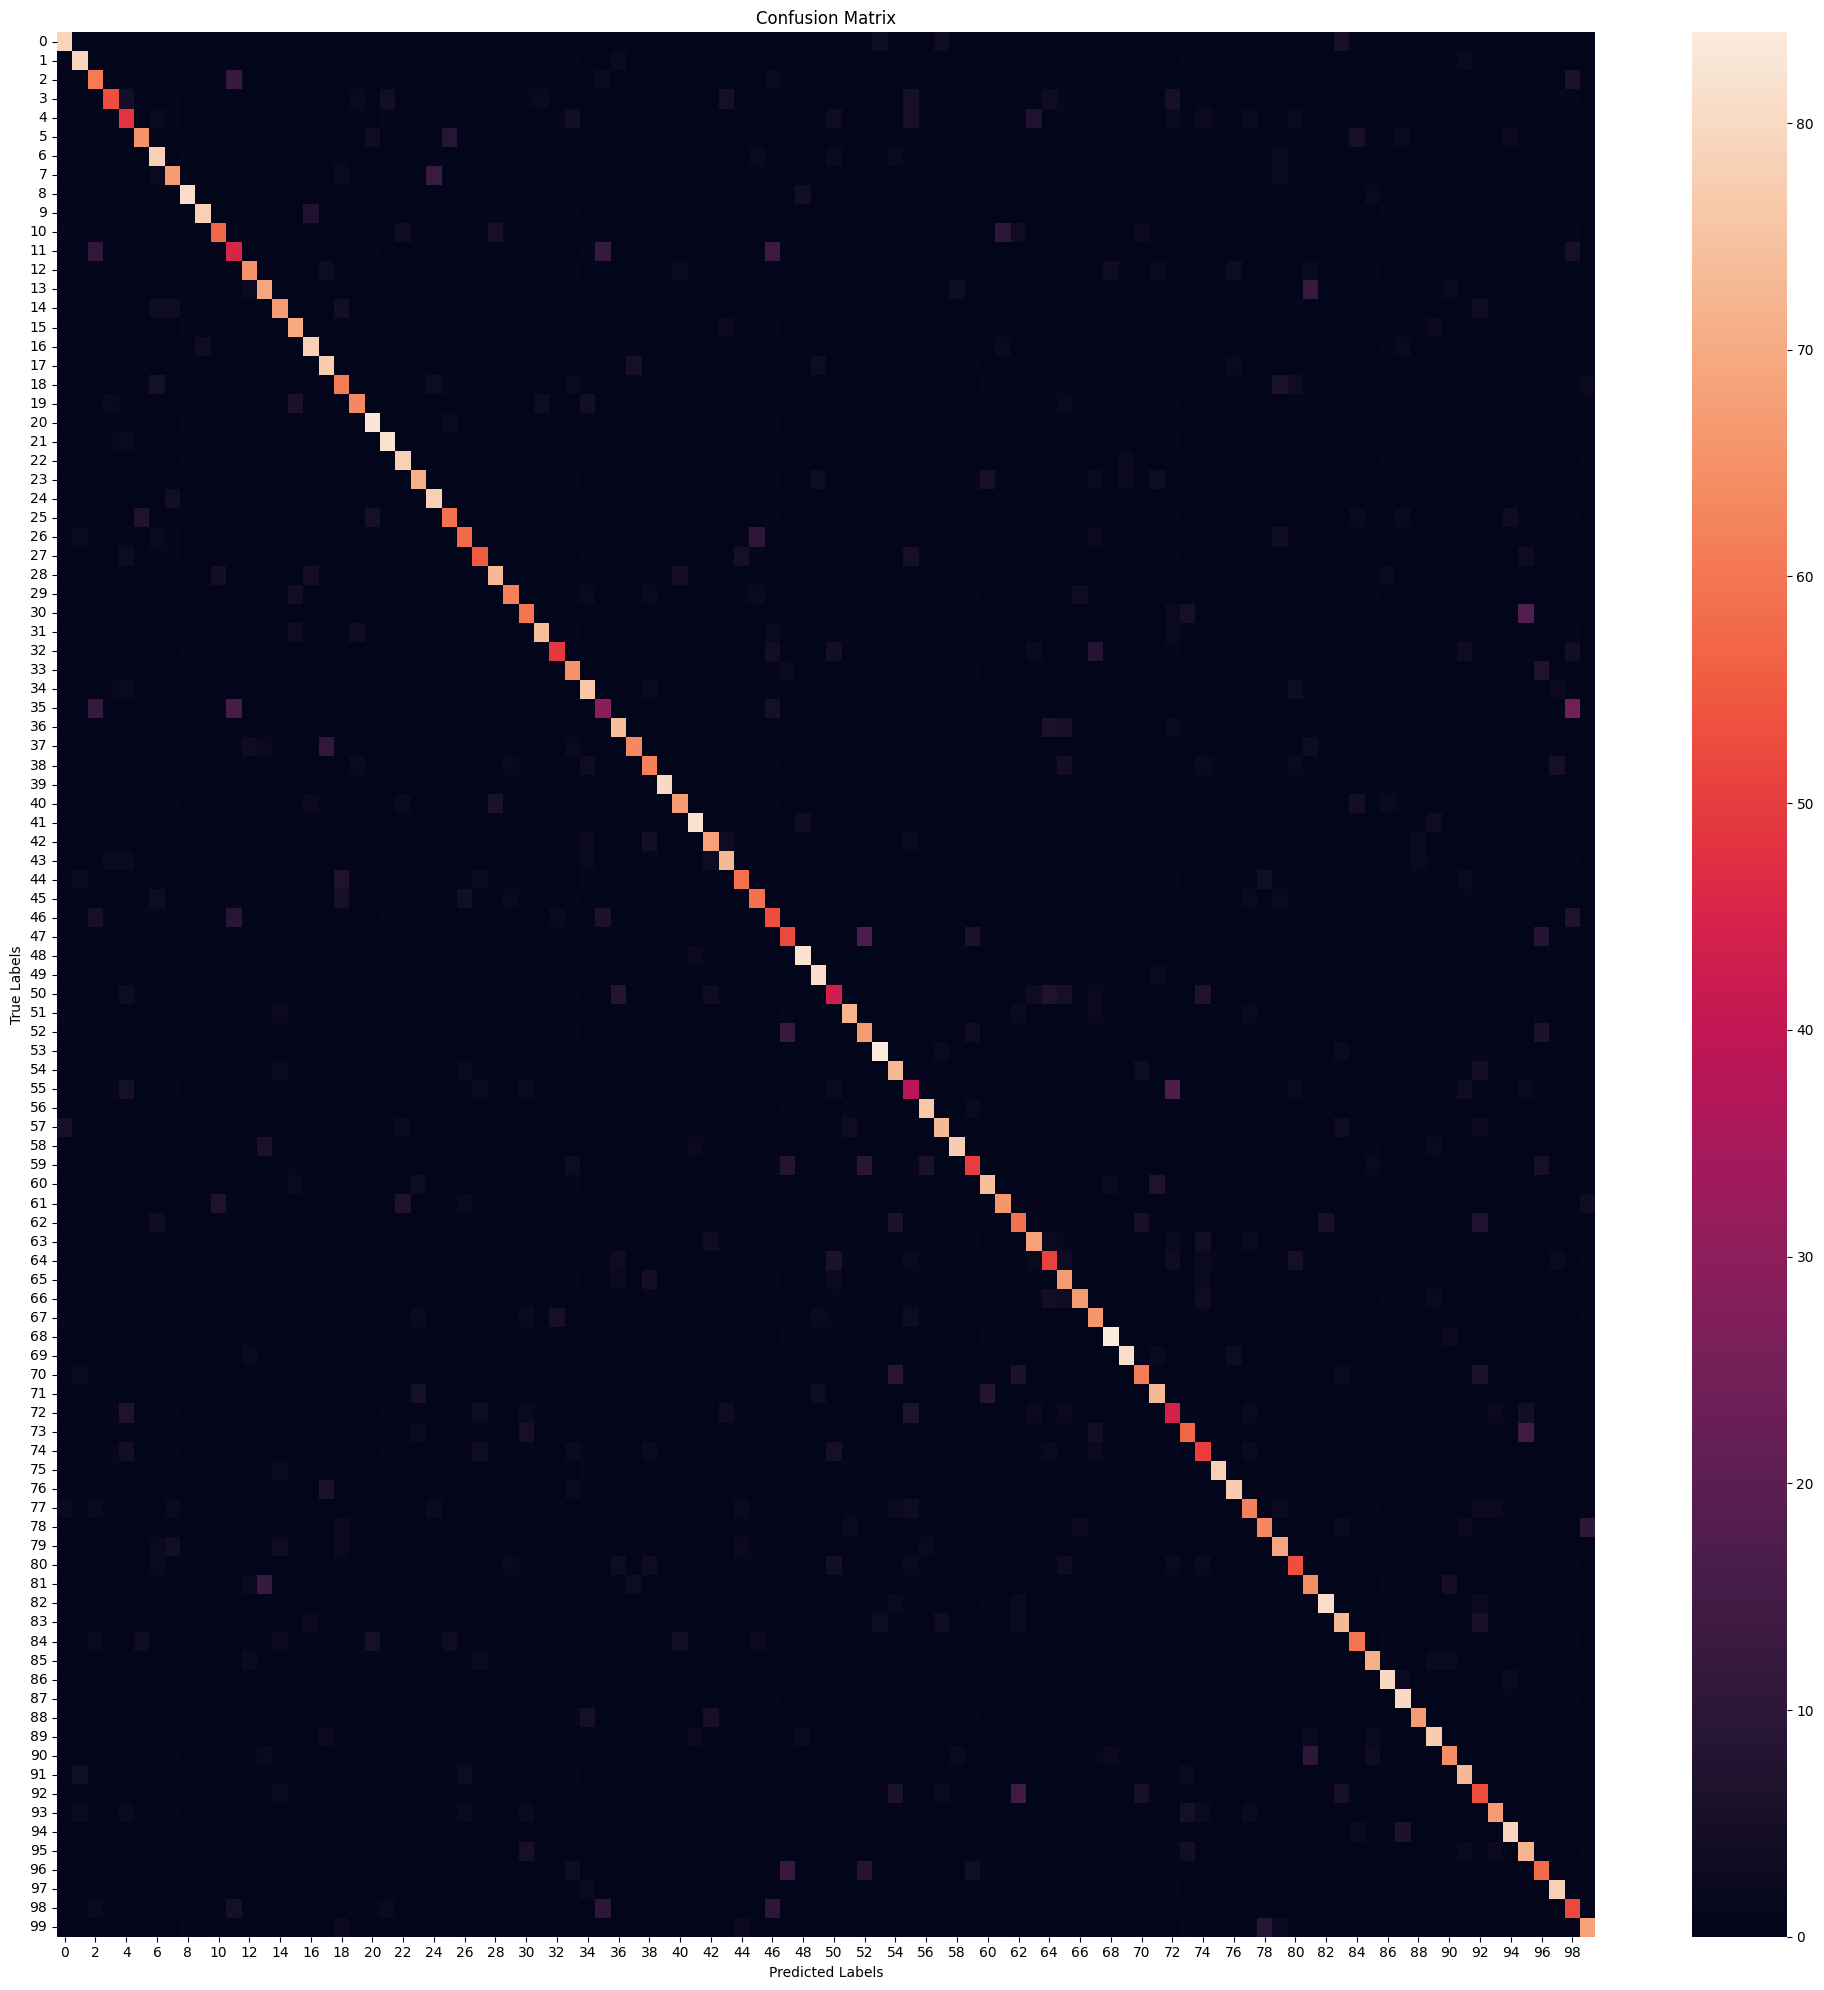

                   precision    recall  f1-score   support

           beaver       0.89      0.88      0.88        90
          dolphin       0.81      0.88      0.84        90
            otter       0.62      0.68      0.65        90
             seal       0.75      0.59      0.66        90
            whale       0.51      0.53      0.52        90
    aquarium fish       0.78      0.72      0.75        90
         flatfish       0.72      0.87      0.79        90
              ray       0.74      0.74      0.74        90
            shark       0.93      0.90      0.92        90
            trout       0.93      0.87      0.90        90
          orchids       0.77      0.63      0.70        90
          poppies       0.49      0.50      0.50        90
            roses       0.72      0.72      0.72        90
       sunflowers       0.73      0.77      0.75        90
           tulips       0.74      0.74      0.74        90
          bottles       0.75      0.78      0.77       

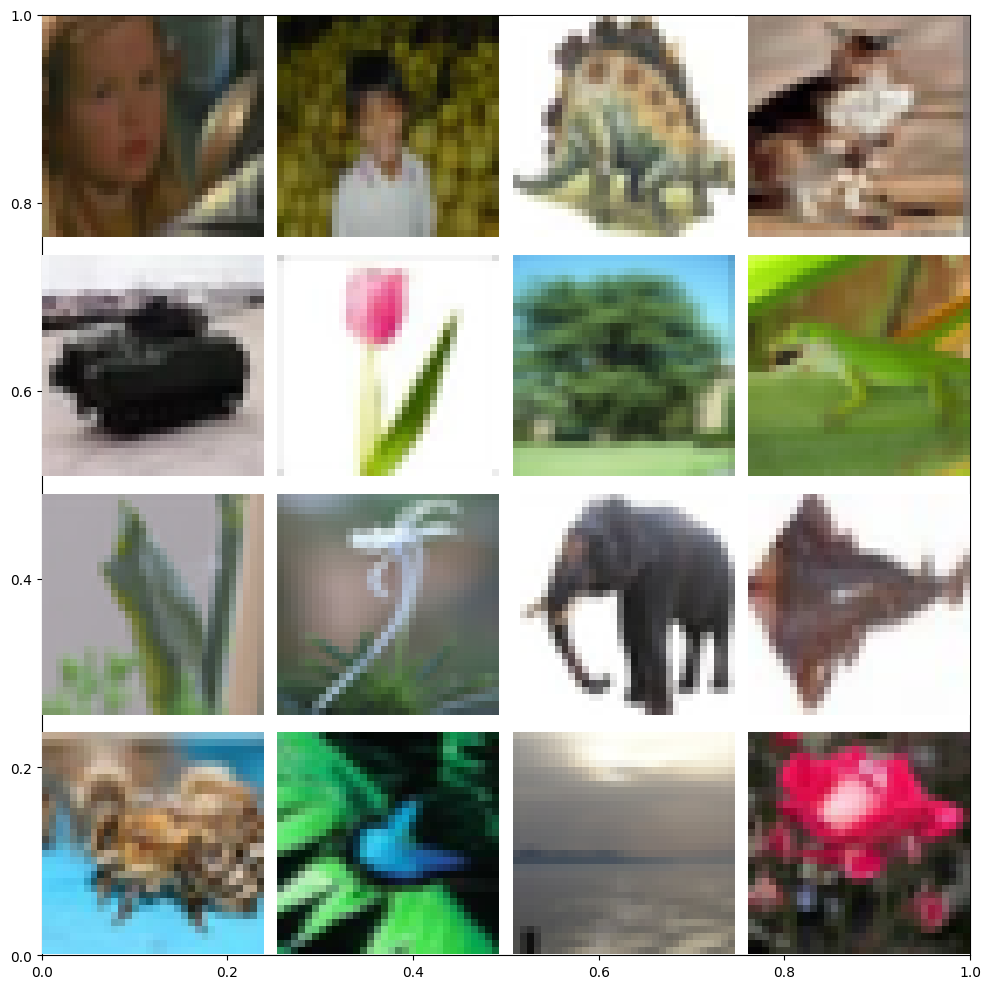

labels[38904].shape: (1,)
imgs[38904].shape: (32, 32, 3)


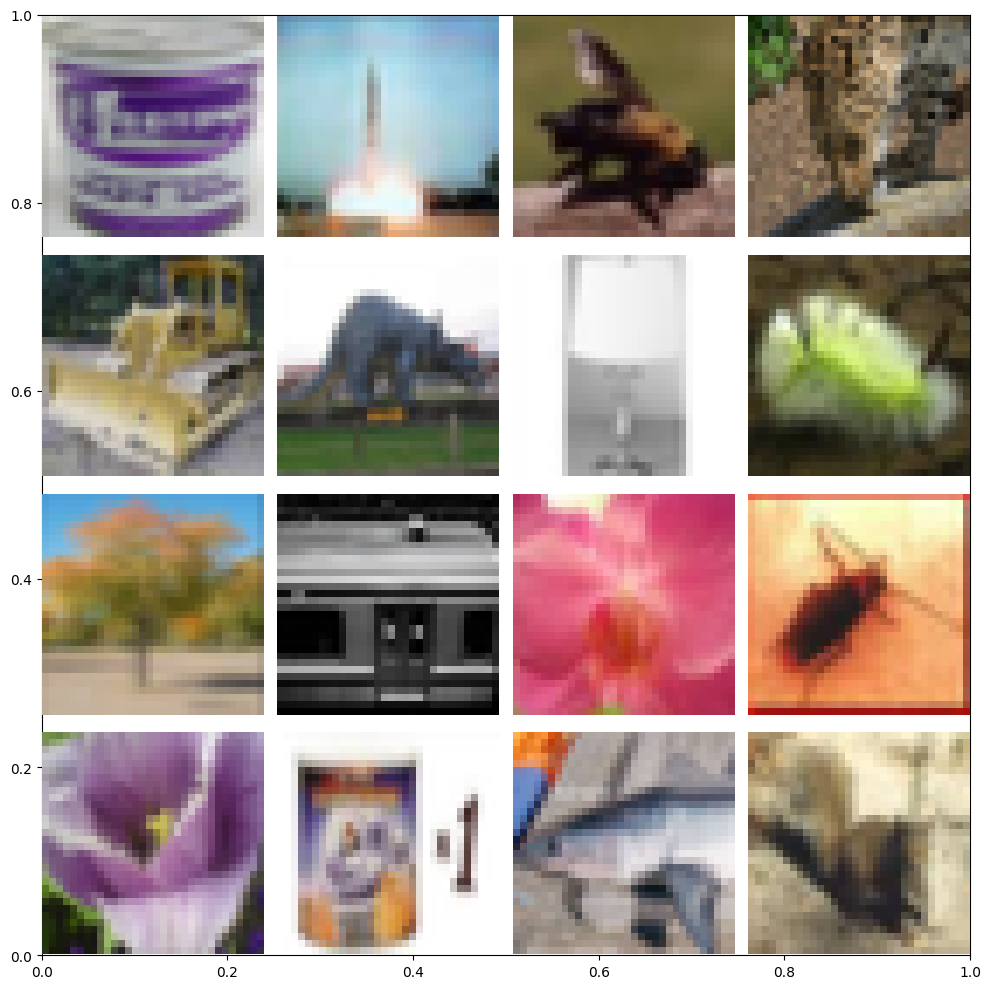

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


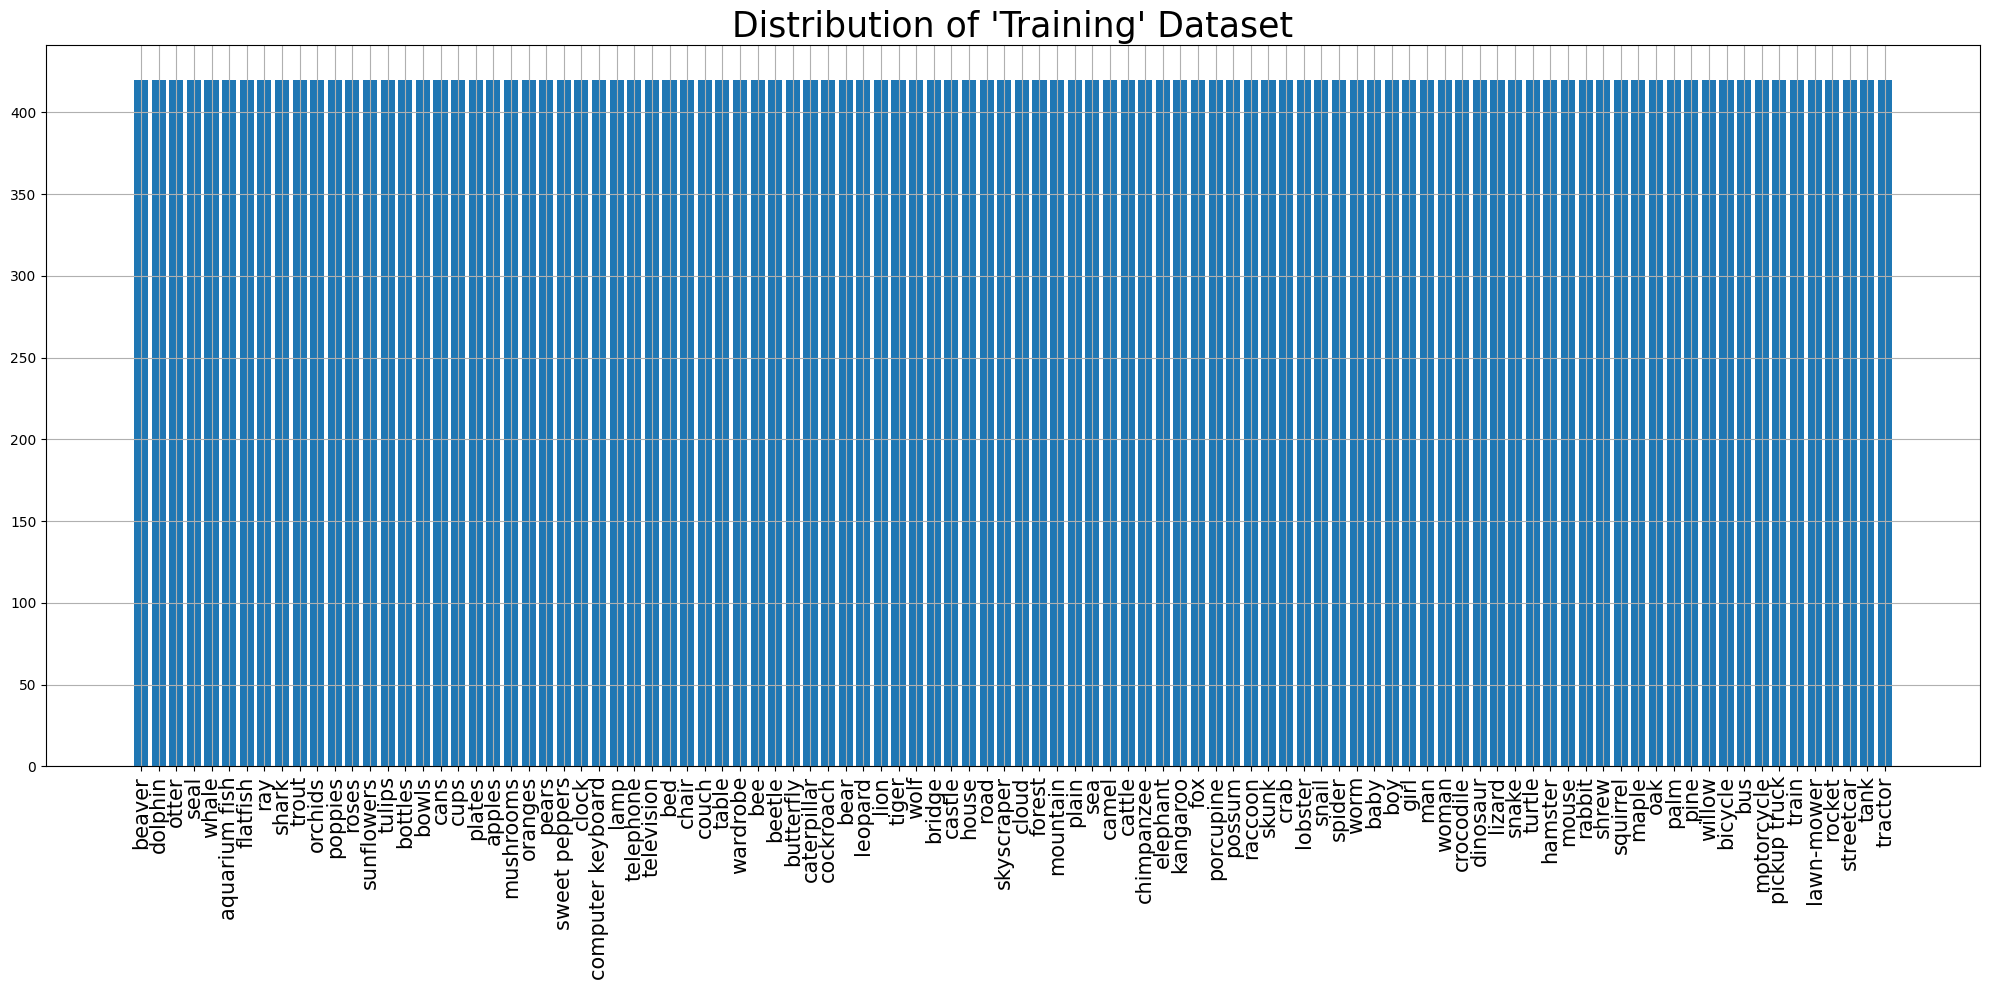

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


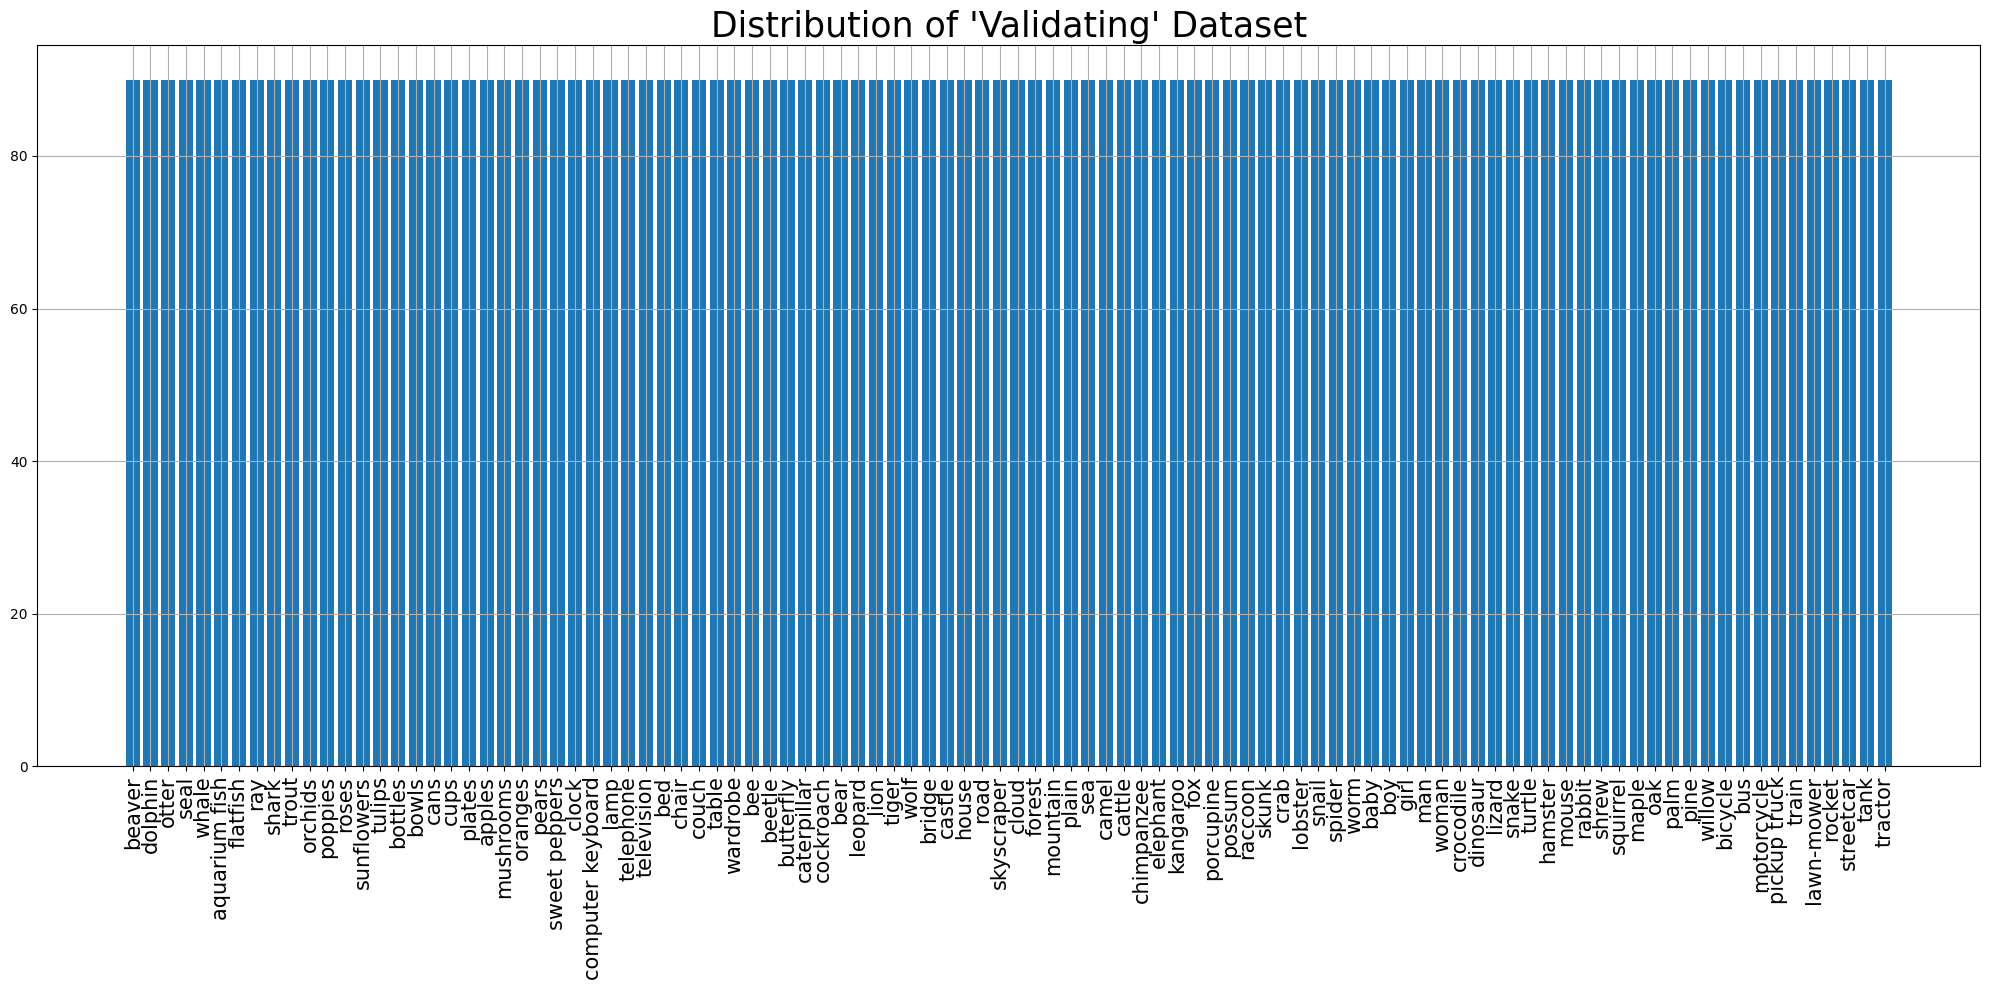

<ipython-input-4-b65b705d857f>:70: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels_names, rotation=90, fontsize=15)


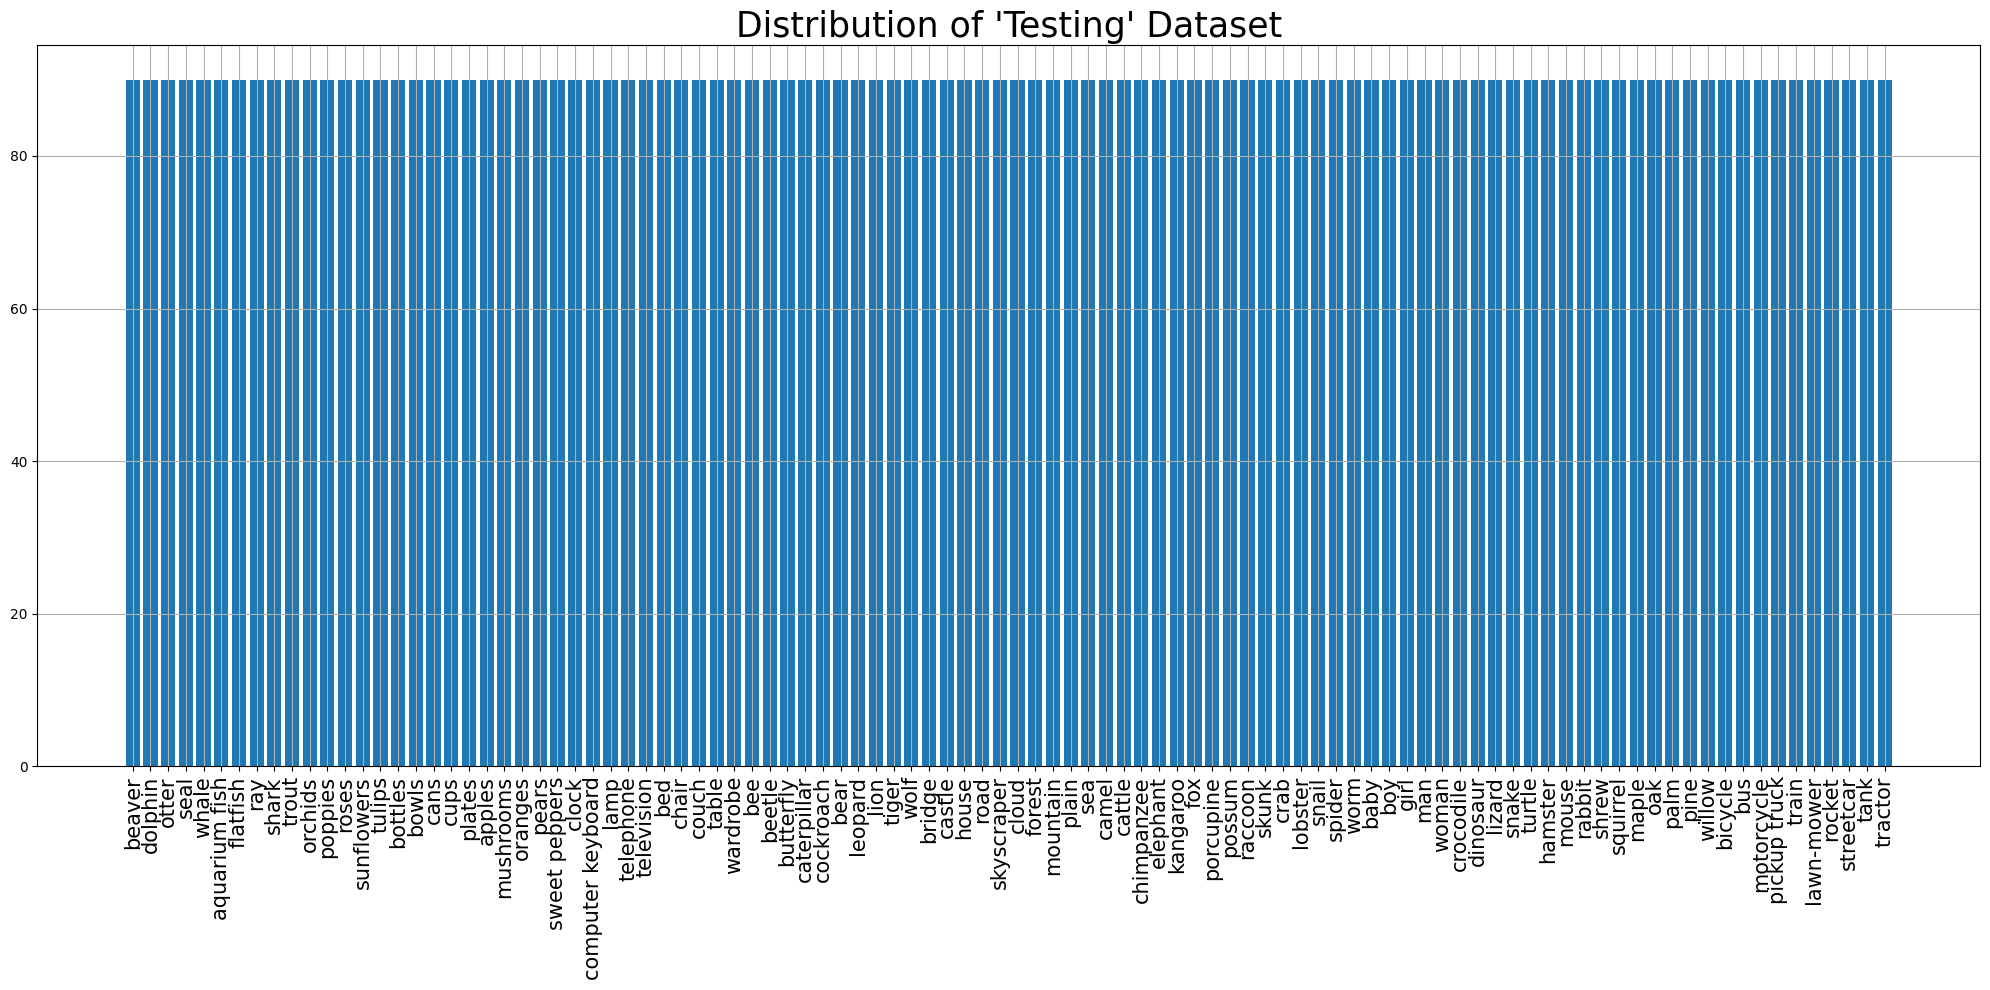

Training dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Validation dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)

Testing dataset:
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100), dtype=tf.float32, name=None))>
Image shape: (64, 224, 224, 3)
Label shape: (64, 100)
<class 'tuple'>
2
<class 'tensorflow.python.framework.ops.EagerTensor'> <class 'tensorflow.python.framework.ops.EagerTensor'>
(64, 224, 224, 3)
(64, 100)
Model input shape: (None, 224, 224, 3)
Model output shape: (None, 100)
2
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(64, 224, 224, 3) (6

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 1,100,388 (4.20 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

Epoch 1/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 42s 48ms/step - accuracy: 0.3851 - f1_score: 0.3813 - loss: 2.5095 - precision: 0.6903 - val_accuracy: 0.6004 - val_f1_score: 0.5974 - val_loss: 1.4368 - val_precision: 0.8042
Epoch 2/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.5911 - f1_score: 0.5882 - loss: 1.4505 - precision: 0.7732 - val_accuracy: 0.6170 - val_f1_score: 0.6141 - val_loss: 1.3625 - val_precision: 0.7965
Epoch 3/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.6432 - f1_score: 0.6404 - loss: 1.2346 - precision: 0.8008 - val_accuracy: 0.6256 - val_f1_score: 0.6229 - val_loss: 1.3353 - val_precision: 0.7879
Epoch 4/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.6825 - f1_score: 0.6801 - loss: 1.0787 - precision: 0.8160 - val_accuracy: 0.6316 - val_f1_score: 0.6305 - val_loss: 1.3209 - val_precision: 0.7768
Epoch 5/25
657/657 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.7109 - f1_score: 0.7089 - loss: 0.9579 - precision: 0.8327 - val_acc

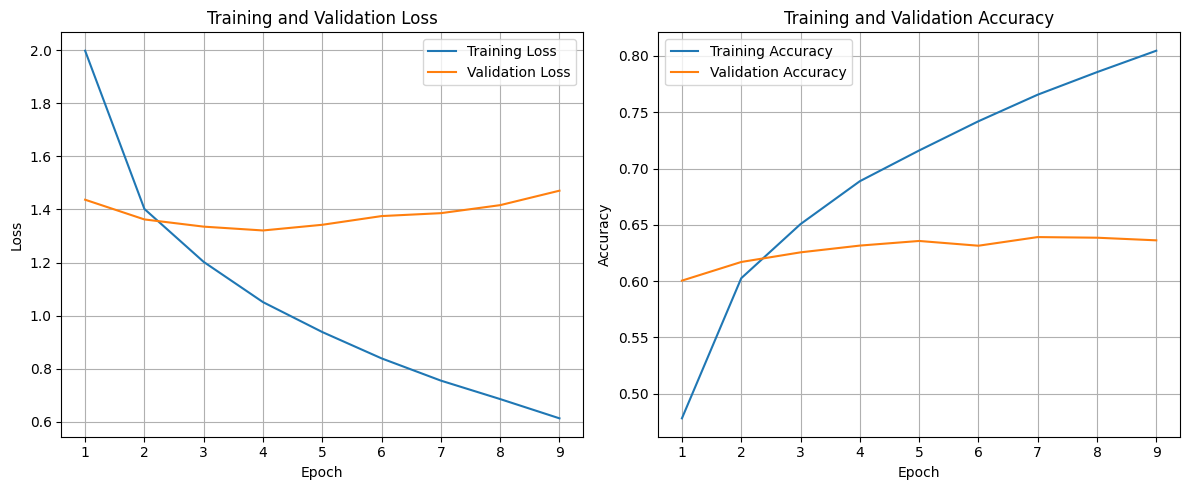

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6161 - f1_score: 0.6096 - loss: 1.3717 - precision: 0.7615
Test Accuracy: 62.86%
Test Loss: 133.00%
Test Precision: 77.59%
Test F1 Scores (Per Class): [82.92682  77.08333  51.54639  46.47887  38.028164 64.44444  58.878494
 64.73429  81.81818  81.6568   56.774185 46.15384  66.666664 51.476784
 60.63829  53.389828 76.28865  72.641495 55.50239  56.953632 77.8443
 72.625694 76.543205 77.01864  74.68353  57.971012 46.69603  47.77777
 75.789474 64.28571  59.740257 65.89595  48.48484  55.660374 64.088394
 24.11347  69.41176  50.793648 49.450542 90.05848  69.36415  81.481476
 62.499992 70.23808  47.999996 42.58064  53.080566 55.83756  81.81818
 82.41757  39.080452 69.51219  63.725483 86.18784  71.26436  33.018864
 77.52808  72.52747  64.17911  52.777775 78.68852  70.99999  63.2258
 65.306114 40.559433 52.12121  57.516335 50.44247  85.27918  83.72092
 67.005066 76.66666  38.974354 47.222214 39.189182 79.365074 82.2335
 52.582157 65.359474 

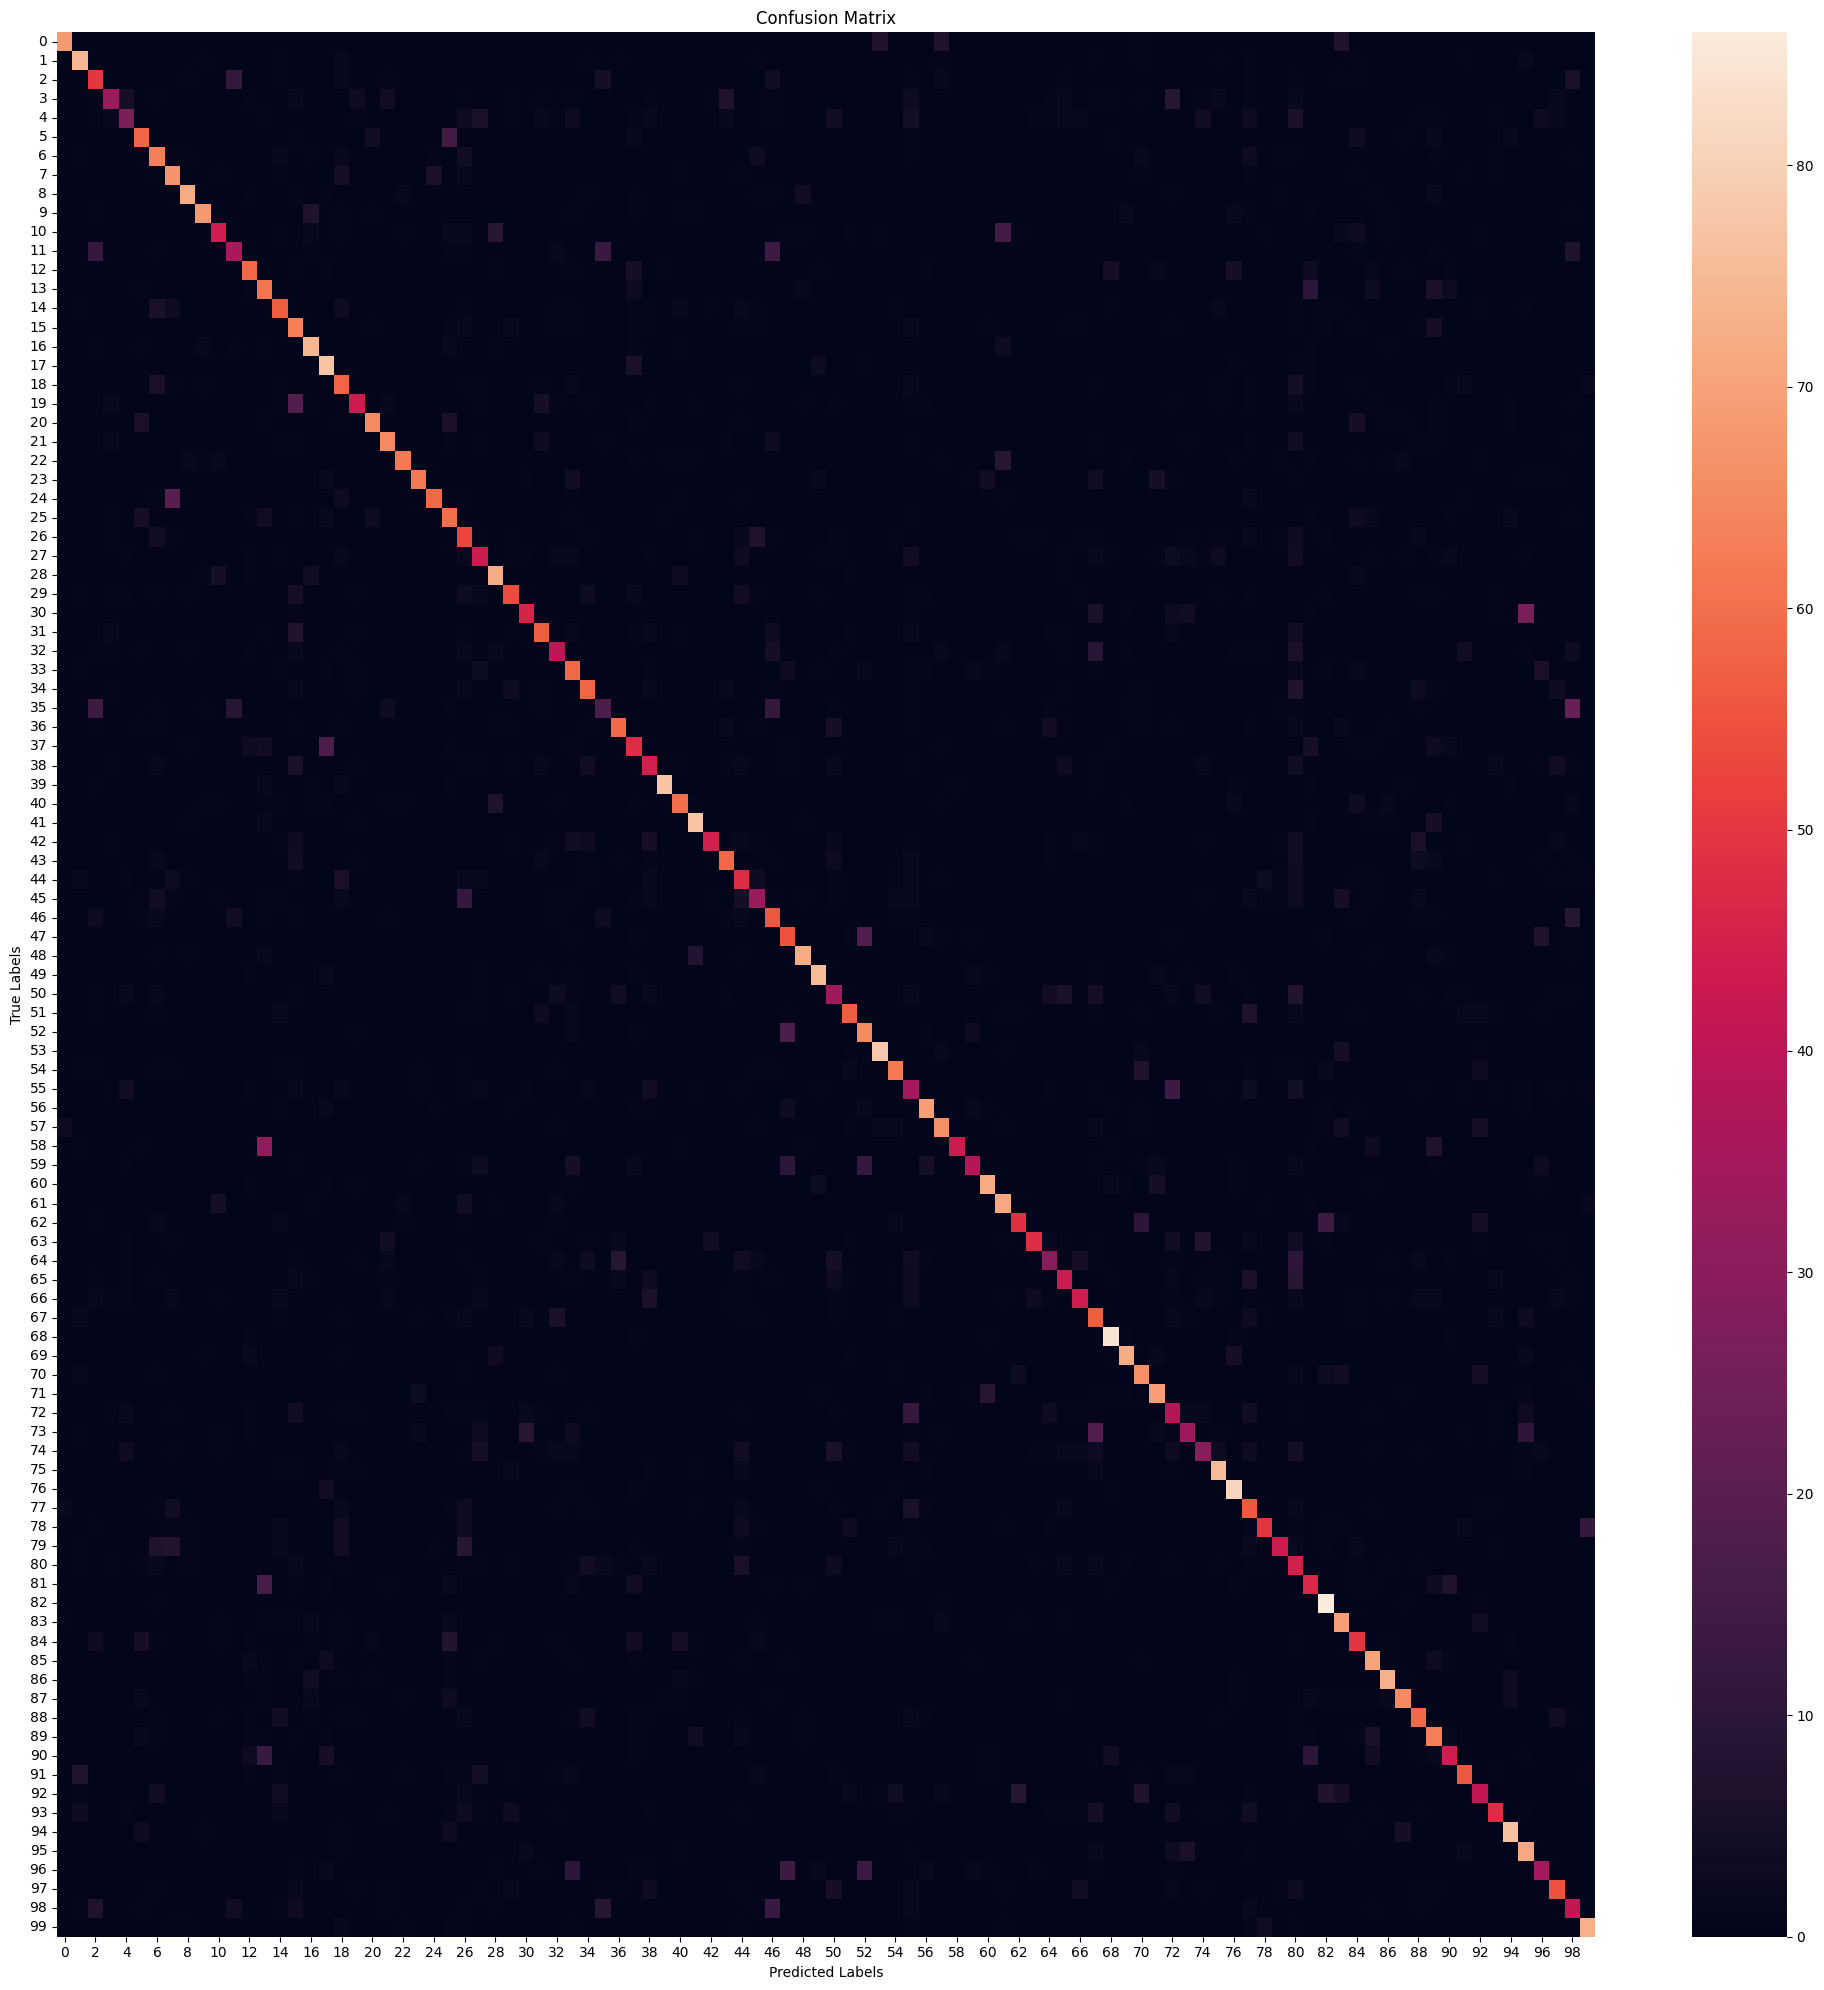

                   precision    recall  f1-score   support

           beaver       0.92      0.76      0.83        90
          dolphin       0.73      0.82      0.77        90
            otter       0.48      0.56      0.52        90
             seal       0.63      0.37      0.46        90
            whale       0.52      0.30      0.38        90
    aquarium fish       0.64      0.64      0.64        90
         flatfish       0.51      0.70      0.59        90
              ray       0.57      0.74      0.65        90
            shark       0.84      0.80      0.82        90
            trout       0.87      0.76      0.81        90
          orchids       0.68      0.49      0.57        90
          poppies       0.55      0.40      0.46        90
            roses       0.68      0.66      0.67        90
       sunflowers       0.41      0.68      0.51        90
           tulips       0.58      0.63      0.61        90
          bottles       0.43      0.70      0.53       

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 100)                 │          51,300 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,665,188 (94.09 MB)

 Trainable params: 24,619,748 (93.92 MB)

 Non-trainable params: 45,440 (177.50 KB)

Epoch 1/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 123s 113ms/step - accuracy: 0.5628 - f1_score: 0.5624 - loss: 1.6490 - precision: 0.7709 - val_accuracy: 0.7306 - val_f1_score: 0.7291 - val_loss: 0.9436 - val_precision: 0.8411
Epoch 2/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 72ms/step - accuracy: 0.7590 - f1_score: 0.7561 - loss: 0.8069 - precision: 0.8645 - val_accuracy: 0.7500 - val_f1_score: 0.7492 - val_loss: 0.8860 - val_precision: 0.8346
Epoch 3/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.8477 - f1_score: 0.8454 - loss: 0.4946 - precision: 0.9163 - val_accuracy: 0.7577 - val_f1_score: 0.7570 - val_loss: 0.8774 - val_precision: 0.8273
Epoch 4/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.9040 - f1_score: 0.9020 - loss: 0.3197 - precision: 0.9464 - val_accuracy: 0.7611 - val_f1_score: 0.7602 - val_loss: 0.8933 - val_precision: 0.8212
Epoch 5/15
657/657 ━━━━━━━━━━━━━━━━━━━━ 47s 71ms/step - accuracy: 0.9418 - f1_score: 0.9397 - loss: 0.2027 - precision: 0.9671 - val_a

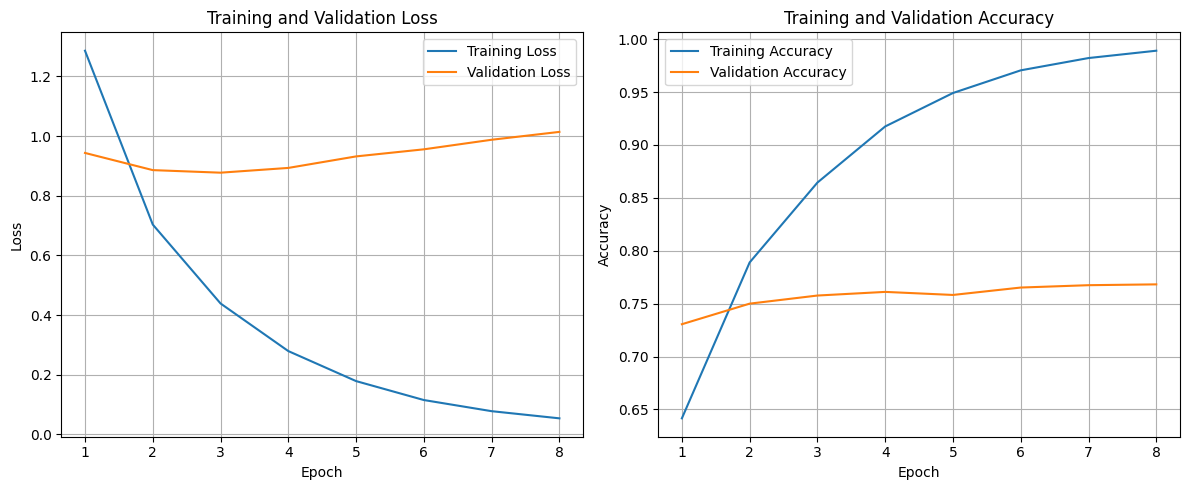

141/141 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7452 - f1_score: 0.7381 - loss: 0.9213 - precision: 0.8140
Test Accuracy: 75.24%
Test Loss: 88.82%
Test Precision: 81.92%
Test F1 Scores (Per Class): [89.502754 87.91208  62.222218 71.26436  52.173912 80.23255  77.24867
 75.789474 92.30768  92.73743  71.345024 50.549446 73.863625 74.86033
 75.53191  75.13227  82.41757  83.422455 64.86485  72.625694 90.217384
 89.13043  84.7826   78.88888  83.69564  72.83237  69.71428  69.31818
 83.14606  73.37277  71.604935 82.285706 62.5      70.45454  78.02197
 38.2716   84.04254  79.166664 73.37277  92.65536  78.07486  87.09677
 76.59574  79.55801  70.83333  55.865913 58.947365 58.757053 91.11111
 84.656075 52.071007 81.91489  67.01031  89.65517  74.747475 45.55555
 83.9779   80.20833  89.14285  58.479523 80.446915 72.94117  65.55555
 78.02197  63.030296 69.47368  80.66298  70.329666 91.489365 92.3913
 73.44632  80.87432  46.242767 72.13114  56.64739  88.76403  85.55555
 73.33333  78.61271  76.

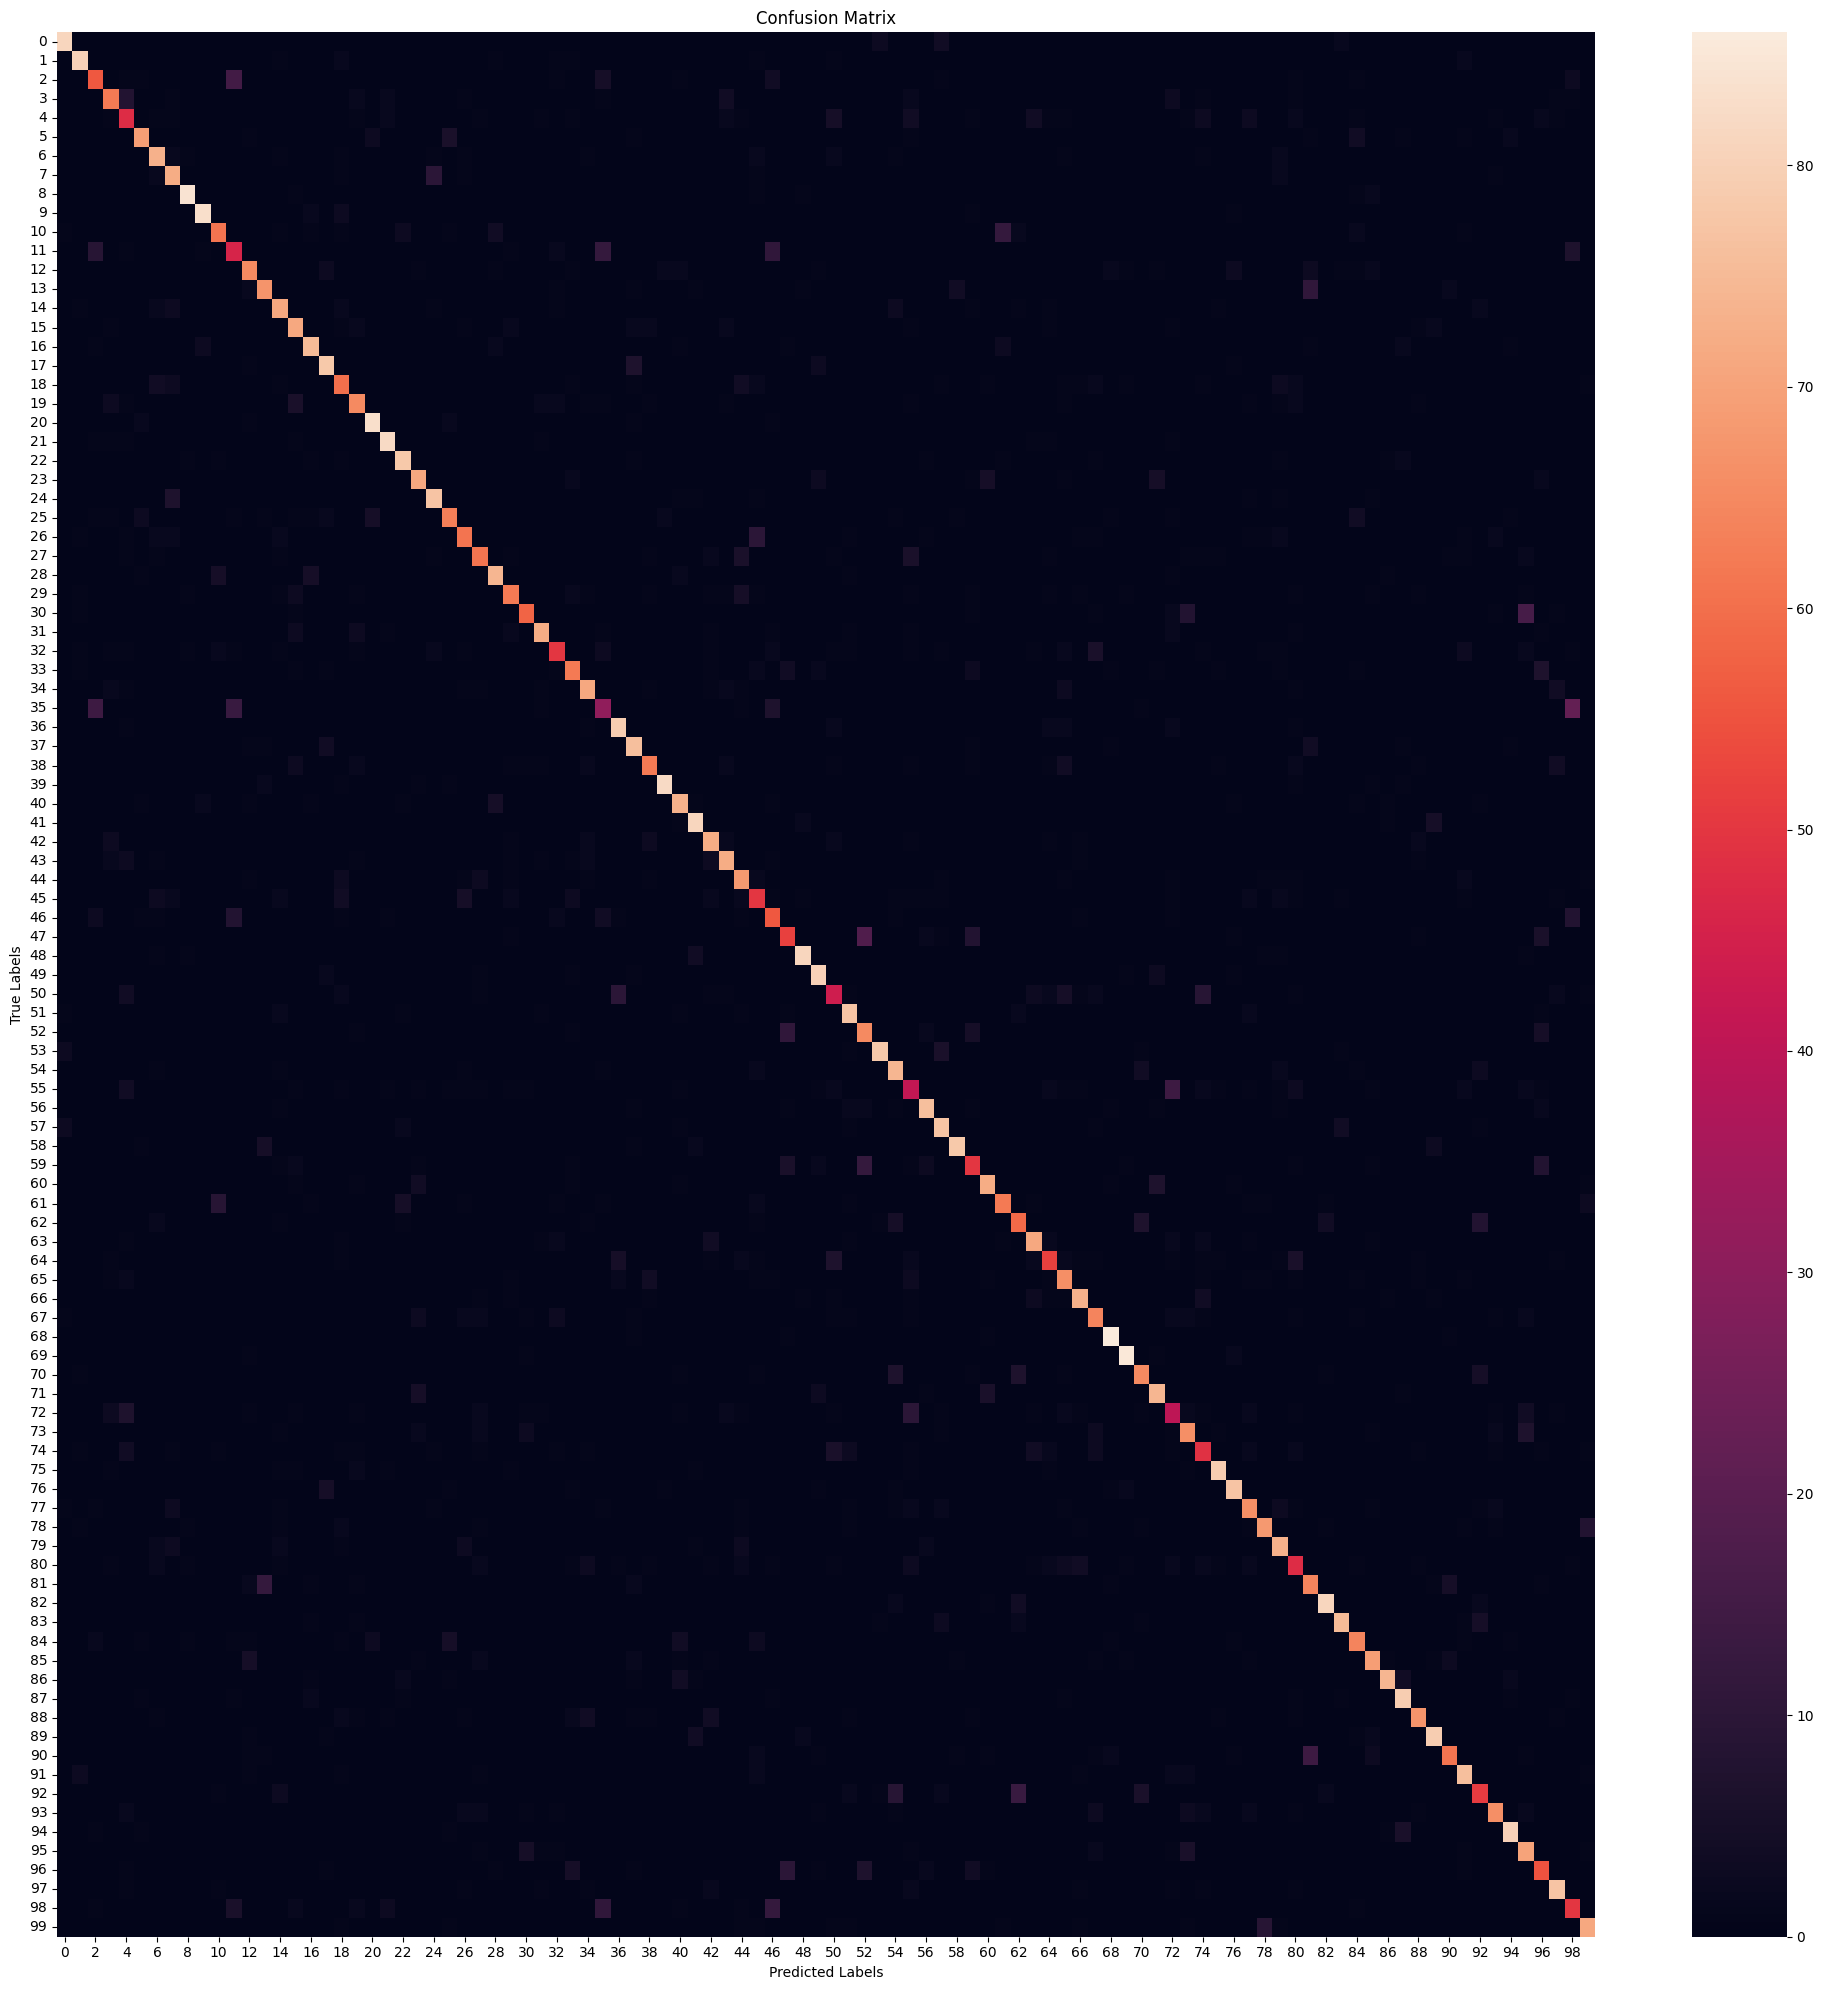

                   precision    recall  f1-score   support

           beaver       0.89      0.90      0.90        90
          dolphin       0.87      0.89      0.88        90
            otter       0.62      0.62      0.62        90
             seal       0.74      0.69      0.71        90
            whale       0.51      0.53      0.52        90
    aquarium fish       0.84      0.77      0.80        90
         flatfish       0.74      0.81      0.77        90
              ray       0.72      0.80      0.76        90
            shark       0.91      0.93      0.92        90
            trout       0.93      0.92      0.93        90
          orchids       0.75      0.68      0.71        90
          poppies       0.50      0.51      0.51        90
            roses       0.76      0.72      0.74        90
       sunflowers       0.75      0.74      0.75        90
           tulips       0.72      0.79      0.76        90
          bottles       0.72      0.79      0.75       

In [4]:
for repeat_2_times in range(2):
    #### <<<<<<<<<<Load and process data>>>>>>>>>>
    # Load CIFAR-100 dataset
    (X_train, y_train), (X_test, y_test) = cifar100.load_data(label_mode='fine')

    # Split (8000) of training data into temporary set
    X_temp, X_train, y_temp, y_train = train_test_split(X_train, y_train, test_size=0.84, stratify=y_train, random_state=42)
    print(f"X_temp.shape: {X_temp.shape}\n")

    # Split temp data into equal validation (4000) and testing (4000) data
    X_temp_val, X_temp_test, y_temp_val, y_temp_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)
    print(f"X_temp_val.shape: {X_temp_val.shape}")
    print(f"y_temp_val.shape: {y_temp_val.shape}")
    print(f"X_temp_test.shape: {X_temp_test.shape}")
    print(f"y_temp_test.shape: {y_temp_test.shape}\n")

    # Split test data into validation (5000) and testing (5000)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)

    # Add temp_val to validation (9000) and temp_test to testing (9000) to get a 70/15/15 data split
    X_val = np.concatenate((X_val, X_temp_val), axis=0)
    y_val = np.concatenate((y_val, y_temp_val), axis=0)
    X_test = np.concatenate((X_test, X_temp_test), axis=0)
    y_test = np.concatenate((y_test, y_temp_test), axis=0)

    print(f"X_train.shape: {X_train.shape}")
    print(f"y_train.shape: {y_train.shape}")
    print(f"X_val.shape: {X_val.shape}")
    print(f"y_val.shape: {y_val.shape}")
    print(f"X_test.shape: {X_test.shape}")
    print(f"y_test.shape: {y_test.shape}\n")

    def display_imgs(imgs, labels):
        plt.subplots(figsize=(10,10))
        for i in range(16):
            plt.subplot(4, 4, i+1)
            k = np.random.randint(0, imgs.shape[0])
            if i == 0:
                print(f"labels[{k}].shape: {labels[k].shape}")
                print(f"imgs[{k}].shape: {imgs[k].shape}")
            plt.imshow(imgs[k])
            #plt.title(labels[k])
            plt.axis('off')
        plt.tight_layout()
        plt.show()

    display_imgs(X_train, y_train)

    # Normalise images (scale to range [0, 1]) - Improves convergence speed & accuracy
    X_train, X_val, X_test = X_train / 255.0, X_val / 255.0, X_test / 255.0
    display_imgs(X_train, y_train)

    labels_names = ['beaver','dolphin','otter','seal','whale','aquarium fish','flatfish','ray','shark','trout',
                   'orchids','poppies','roses','sunflowers','tulips','bottles','bowls','cans','cups','plates',
                   'apples','mushrooms','oranges','pears','sweet peppers','clock','computer keyboard','lamp',
                   'telephone','television','bed','chair','couch','table','wardrobe','bee','beetle','butterfly',
                   'caterpillar','cockroach','bear','leopard','lion','tiger','wolf','bridge','castle','house',
                   'road','skyscraper','cloud','forest','mountain','plain','sea','camel','cattle','chimpanzee',
                   'elephant','kangaroo','fox','porcupine','possum','raccoon','skunk','crab','lobster','snail',
                   'spider','worm','baby','boy','girl','man','woman','crocodile','dinosaur','lizard','snake',
                   'turtle','hamster','mouse','rabbit','shrew','squirrel','maple','oak','palm','pine','willow',
                   'bicycle','bus','motorcycle','pickup truck','train','lawn-mower','rocket','streetcar','tank',
                   'tractor']

    class_distrib(y_train, labels_names, "Training")
    class_distrib(y_val, labels_names, "Validating")
    class_distrib(y_test, labels_names, "Testing")

    # Create TensorFlow datasets

    batch_size = 64
    
    train_dataset_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # DEBUG augment
    #train_dataset_aug = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
    #                 .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    #                 .batch(batch_size)
    #                 .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset = train_dataset_#.concatenate(train_dataset_aug)
    
    val_dataset = (tf.data.Dataset.from_tensor_slices((X_val, y_val))
                   .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                      tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                   .batch(batch_size)
                   .prefetch(tf.data.experimental.AUTOTUNE))

    test_dataset = (tf.data.Dataset.from_tensor_slices((X_test, y_test))
                     .map(lambda x, y: (tf.image.resize(x, (224, 224)),
                                        tf.squeeze(tf.one_hot(y, depth=100, dtype=tf.float32))))  # Remove extra dimension
                    .batch(batch_size)
                    .prefetch(tf.data.experimental.AUTOTUNE))

    print(f"Training dataset:\n {train_dataset}")
    for img, lbl in train_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nValidation dataset:\n {val_dataset}")
    for img, lbl in val_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl
    print(f"\nTesting dataset:\n {test_dataset}")
    for img, lbl in test_dataset.take(1):
        #if isinstance(batch, tuple) and len(batch) == 2:
        print(f"Image shape: {img.shape}")  # Should be (batch_size, 224, 224, 3)
        print(f"Label shape: {lbl.shape}")  # Should be (batch_size, 10)
        del img,lbl


    #### <<<<<<<<<<Pre-trained model>>>>>>>>>>
    # Load ResNet50 pre-trained on ImageNet (w/out the top classification layer which is designed for ImageNet (diff dataset))
    resnet_50_base = tf.keras.applications.ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    # Freeze the layers of VGG16 so they don't get updated during training - can unfreeze for fine tuning later
    resnet_50_base.trainable = False

    for layer in resnet_50_base.layers:
        if isinstance(layer, tf.keras.layers.Conv2D):
            layer.kernel_regularizer = tf.keras.regularizers.l2(3e-2) # DEBUG l2

    # Add custom classification layers for CIFAR-100 (100 classes) - adapt model to CIFAR-100
    model = models.Sequential([
        resnet_50_base,
        layers.GlobalAveragePooling2D(), # Better for ResNet than Flatten
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.6), # DEBUG dropout
        layers.Dense(100, activation='softmax')  # CIFAR-100 has 100 classes
    ])

    for sample in test_dataset.take(1):
        print(type(sample))  # Should be <class 'tuple'>
        print(len(sample))  # Should be 2
        print(type(sample[0]), type(sample[1]))  # Both should be <class 'tensorflow.Tensor'>
        print(sample[0].shape)  # Should be (batch_size, 224, 224, 3)
        print(sample[1].shape)  # Should be (batch_size, 100)
    print(f"Model input shape: {model.input_shape}")
    print(f"Model output shape: {model.output_shape}")
    sample = next(iter(test_dataset.as_numpy_iterator()))
    print(len(sample))  # Should be 2
    print(type(sample[0]), type(sample[1]))  # Both should be <class 'numpy.ndarray'>
    print(sample[0].shape, sample[1].shape)  # Should match model input and output
    print("\n")
    #for x, y in test_dataset.take(1):
    #    print(type(x), type(y))  # Both should be <class 'tensorflow.Tensor'>
    #for x_batch, y_batch in test_dataset.take(1):
    #    test_loss, test_acc = model.evaluate(x_batch, y_batch)
    #    print(f"Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    # Compile the model
    #tensorboard_callback = keras.callbacks.TensorBoard(log_dir="./logs")
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-3, weight_decay=3e-2), # DEBUG weight
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>
    early_stopping = EarlyStopping(monitor='val_loss', # or val_accuracy
                                   patience=5, # Num. epochs with no improvements - help void overfitting
                                   restore_best_weights=True)
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', # or val_accuracy
    #                              factor=0.1, # Reduce lr by a factor
    #                              patience=3, # Num epochs w/ no improvement
    #                              min_lr=1e-6, # Min lr
    #                              verbose=1)
    #tensorboard = TensorBoard(log_dir='./logs', # Logs directory
    #                         histogram_freq=1, # Logs histograms for weights/activations
    #                         write_graph=True, # Logs graph of model
    #                         write_images=True) # Log images like weight histogram
    checkpoint = ModelCheckpoint('best_model.h5', # Path where the best model will be saved
                                 monitor='val_loss', # What to monitor (validation loss)
                                 save_best_only=True, # Only save model when validation loss improves
                                 mode='min', # Looking to minimse the validation loss
                                 verbose=1) # Print out message when saving model
    #cvs_logger = CSVLogger('training_log.csv', seperator=',', append=True) # Save train metrics to analyse

    # Train the model
    history = model.fit(train_dataset, validation_data=val_dataset, epochs=25,
                        batch_size=batch_size, callbacks=[early_stopping, checkpoint], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history.history['loss'])+1)
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model = load_model('best_model.h5')
    results = model.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))
    #tensorboard --logdir==path_to_your_logs

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    # Finally, display the hist DataFrame.
    hist

    #### <<<<<<<<<<Fine-Tune>>>>>>>>>>
    # Adapt Model
    for layer in resnet_50_base.layers:
        layer.trainable = True # Allow layers to be updated

    # Compile again w/ lower learning rate (prevents destroying learned features)
    model.compile(optimizer=optimizers.Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'precision', 'f1_score'])

    model.summary()

    #### <<<<<<<<<<Modify Dataset>>>>>>>>>>


    # DEBUG augment
    train_dataset_aug_ = (tf.data.Dataset.from_tensor_slices((X_train, y_train))
                     .map(augment_dataset, num_parallel_calls=tf.data.experimental.AUTOTUNE)
                     .batch(batch_size)
                     .prefetch(tf.data.experimental.AUTOTUNE))

    # Combine the original dataset and the augmented dataset
    train_dataset_aug = train_dataset_.concatenate(train_dataset_aug_) # Not val or test as augment train helps generalise better, but want to provide consistent benchmark for eval perf

    #### <<<<<<<<<<Train Model & Track Training/Validation Error>>>>>>>>>>

    # Train the model
    history_fine_tune = model.fit(train_dataset_aug, validation_data=val_dataset, epochs=15,
                                  batch_size=batch_size, callbacks=[early_stopping, checkpoint_fine_tune], verbose=1)

    #### <<<<<<<<<<Plot Training & Validation Error>>>>>>>>>>

    # Extract loss and accuracy
    epochs = range(1,len(history_fine_tune.history['loss'])+1)
    train_loss = history_fine_tune.history['loss']
    val_loss = history_fine_tune.history['val_loss']
    train_acc = history_fine_tune.history['accuracy']
    val_acc = history_fine_tune.history['val_accuracy']

    plot_evidence(epochs, train_loss, val_loss, train_acc, val_acc)

    #### <<<<<<<<<<Evaluate Model on Test Data>>>>>>>>>>

    # Evaluate on test data
    model_fine_tune = load_model('best_model_fine_tune.h5')
    results = model_fine_tune.evaluate(test_dataset)
    test_loss = results[0]
    test_acc = results[1]
    test_precision = results[2]
    test_f1_scores = results[3]
    print(f"Test Accuracy: {test_acc*100:.2f}%")
    print(f"Test Loss: {test_loss}")
    print(f"Test Precision: {test_precision*100:.2f}%")
    print(f"Test F1 Scores (Per Class): {test_f1_scores.numpy()*100}")
    print(f"Average Test F1 Scores:{np.average(test_f1_scores.numpy()*100):.2f}\n")

    #### <<<<<<<<<<Generate Confusion Matrix>>>>>>>>>>

    # Get predictions
    X_test_revised = tf.image.resize(X_test, (224, 224))
    y_pred = model_fine_tune.predict(X_test_revised)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = y_test.flatten()

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

    # Plot confusion matrix
    plt.figure(figsize=(20, 20))
    sns.heatmap(conf_matrix) #cmap='Blues', fmt='d'
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    print(classification_report(y_true_classes, y_pred_classes, target_names=labels_names))

    # Create a DataFrame from the history of the training and store the epoch values.
    hist = pd.DataFrame(history_fine_tune.history)
    hist['epoch'] = history_fine_tune.epoch

    # Finally, display the hist DataFrame.
    hist